<p style="font-size: 18pt; line-height: 24pt;">Analysis, code development, and plots for NANOGrav's <i>Modeling the uncertainties of solar-system ephemerides for robust gravitational-wave searches with pulsar timing arrays</i>.</p>

Michele Vallisneri, developed across 2018-2020. Copyright 2019 California Institute of Technology.

1. Where we import all the Python modules we need (and possibly install a few). 
2. Where we code up functions to handle orbits, frames, Roemer delays, and some plots.
3. Where we list the masses of the planets and their errors.
4. Where we load SSEs and set our standard time span.
5. Where we verify the changes in Jupiter and Saturn's orbits between consecutive SSEs.
6. Where we compare the changes in Earth - Sun (trivial) and Sun - SSB (crucial) between SSEs.
7. Where we plot the change in Roemer delays (~ Sun - SSB) between SSEs, and after timing-model subtractions.
8. Where we make orbit partials (and SVDed bases) using a quasi-Keplerian model of Jupiter and Saturn's orbits.
9. Where we make orbit partials (and SVDed bases) using Brouwer and Clemence's "set III" parametrization of Jupiter's orbital elements.
10. Where we make dynamical orbit partials using an integrator of solar-system motions, and establish that they span the same subspace of set III Jupiter partials.
11. Where we look at Roemer delay differences after subtracting combinations of the orbit partials.
12. Where we plot MCMC posteriors for GW amplitudes and BayesEphem corrections.

## Python imports

Several imports that we'll need later. Most would be included in the standard Anaconda distribution, but a few need installation separately.

In [2]:
import sys
import os
import math
import functools
import random

`tabulate` makes nice tables, `corner` nice corner plots, `ephem` handles dates and such, `jplephem` reads SSE files in the "spice" format.

In [3]:
# conda install tabulate
# conda install corner -c conda-forge
# conda install ephem
# pip install jplephem

In [4]:
import tabulate
import corner
import ephem
from jplephem.spk import SPK

In [5]:
from IPython.display import HTML, display

In [6]:
import numpy as np

import scipy.optimize as so
import scipy.linalg as sla
import scipy.integrate as si
import scipy.interpolate as sin

import matplotlib.pyplot as pp

%matplotlib inline

For bootstrapped estimates.

In [7]:
import astropy.stats as aps

## Code: orbits, frame rotations, Roemer delays, plotting

Get orbit from SSE as position [s] and velocity [s/s] vectors. Takes planet number, vector of Julian dates, SSE kernel. Note that Julian dates (abbreviated JD) are the continuous count of days and fractions since noon Universal Time on January 1, 4713 BC (on the Julian calendar).

In [8]:
csec = 299792.458 # km/s

def getplanet(i, jdates, bsp):
    """Return a len(jdates) x 3 numpy array of the orbit for planet i,
    following the ephemeris file numbering (3 is Earth, 10 is Sun).
    
    Special cases: 310 is Sun to Earth, 399 is Earth bary + nutation,
    0 is again Sun.
    
    Returns pos [s], vel [1]."""
    
    if not isinstance(bsp, SPK):
        bsp = SPK.open('bsp/' + bsp)

    # get pos, vel in km, km/day
    if i == 399:
        e1, e2 = bsp[0,3].compute_and_differentiate(jdates), bsp[3,399].compute_and_differentiate(jdates)
        pos, vel = e1[0] + e2[0], e1[1] + e2[1]
    elif i == 310:
        e1, e2 = bsp[0,3].compute_and_differentiate(jdates), bsp[0,10].compute_and_differentiate(jdates)
        pos, vel = e1[0] - e2[0], e1[1] - e2[1]
    else:
        pos, vel = bsp[0,10 if i == 0 else i].compute_and_differentiate(jdates)
    
    # s, s/s
    return pos.T / csec, vel.T / csec / 86400

SSEs are natively in SSB-centric equatorial coordinates. Here's the ecliptic to equatorial roundtrip.

In [9]:
# e_ecl = 23.43704 * math.pi / 180
e_ecl = 23.43928 * math.pi / 180

M_ecl = np.array([[1, 0,               0],
                  [0, math.cos(e_ecl),-math.sin(e_ecl)],
                  [0, math.sin(e_ecl), math.cos(e_ecl)]])

def ecl2eq_vec(x):
    """Rotate (n,3) vector time series from ecliptic to equatorial."""
    
    return np.einsum('jk,ik->ij', M_ecl, x)
    
def eq2ecl_vec(x):
    """Rotate (n,3) vector time series from equatorial to ecliptic."""

    return np.einsum('kj,ik->ij', M_ecl, x)

Frame rotations, see https://stackoverflow.com/questions/6802577/python-rotation-of-3d-vector

In [10]:
from scipy.linalg import expm

def rot_euler(v, xyz, ecliptic=False):
    '''Rotate vector v (or array of vectors) by the euler angles xyz '''

    if ecliptic:
        v = eq2ecl_vec(v)
    
    for theta, axis in zip(xyz, np.eye(3)):
        v = np.einsum('ij,jk->ik',v,expm(np.cross(np.eye(3),axis*(-theta))))

    if ecliptic:
        v = ecl2eq_vec(v)
        
    return v

Another version of frame rotations: either can be used, and it checks out.

In [11]:
def euler2mat(z=0, y=0, x=0):
    '''Return matrix for rotations around z, y and x axes,
    performed in that order. Adapted from from https://github.com/nipy/nibabel.'''
    
    Ms = []
    if z:
        cosz, sinz = math.cos(z), math.sin(z)
        Ms.append(np.array([[cosz, -sinz, 0],
                            [sinz, cosz, 0],
                            [0, 0, 1]]))
        
    if y:
        cosy, siny = math.cos(y), math.sin(y)
        Ms.append(np.array([[cosy, 0, siny],
                            [0, 1, 0],
                            [-siny, 0, cosy]]))
        
    if x:
        cosx, sinx = math.cos(x), math.sin(x)
        Ms.append(np.array([[1, 0, 0],
                            [0, cosx, -sinx],
                            [0, sinx, cosx]]))
        
    return functools.reduce(np.dot, Ms[::-1]) if Ms else np.eye(3)

def euler2mat_rotate(array,x):
    # array is 3 or n x 3
    # matrix is 3 x 3 or n x 3 x 3 if x is n
    
    if isinstance(x[0],np.ndarray):
        assert x[0].shape[0] == array.shape[0]

        ret = np.zeros((x[0].shape[0],3),'d')
        for i in range(array.shape[0]):
            ret[i,:] = np.dot(euler2mat(x[0][i],x[1],x[2]),array[i,:].T)

        return ret
    else:
        return np.dot(euler2mat(x[0],x[1],x[2]),array.T).T

Basic vector algebra.

In [12]:
def vdot(v1, v2):
    return np.einsum('ij,ij', v1, v2)
    
def norm(v):
    return np.sqrt(vdot(v, v))
    
def vnorm(v):
    return v / norm(v)

Compute the difference between the orbits of planet `p` between two SSEs; if `rotate=True`, project out the best-fit rotation; if `dotrend=True` remove also a rotation rate along the z axis. If `ecliptic=True`, rotate in the ecliptic, not equatorial frame.

In [13]:
def getdiff(p, jdates, bsp1, bsp2, dorotate=False, dotrend=False, ecliptic=False):
    global v1n, v2n, v3n
    
    pos1, _ = getplanet(p,jdates,bsp1)
    pos2, _ = getplanet(p,jdates,bsp2)
    
    diff = pos1 - pos2
    
    if dorotate == True:
        dtheta = 1e-3

        v1n = vnorm(0.5 * (rot_euler(pos1, [dtheta,0,0], ecliptic) - rot_euler(pos1, [-dtheta,0,0], ecliptic)) / dtheta)
        v2n = vnorm(0.5 * (rot_euler(pos1, [0,dtheta,0], ecliptic) - rot_euler(pos1, [0,-dtheta,0], ecliptic)) / dtheta)
        v3n = vnorm(0.5 * (rot_euler(pos1, [0,0,dtheta], ecliptic) - rot_euler(pos1, [0,0,-dtheta], ecliptic)) / dtheta)

        v4n = vnorm(v3n * np.linspace(-1,1,v1n.shape[0])[:,np.newaxis])
    
        v2n = vnorm(v2n - vdot(v2n,v1n) * v1n)        
        v3n = vnorm(v3n - vdot(v3n,v1n) * v1n - vdot(v3n,v2n) * v2n)
        v4n = vnorm(v4n - vdot(v4n,v1n) * v1n - vdot(v4n,v2n) * v2n - vdot(v4n,v3n) * v3n)
    
        for vn in [v1n,v2n,v3n] + ([v4n] if dotrend else []):
            diff = diff - vdot(diff,vn) * vn        
    elif dorotate == 'debug':
        def res(x):
            r = pos1 - euler2mat_rotate(pos2, x)
            return math.sqrt(np.sum(r*r)/len(r))

        x = so.fmin(res, [0,0,0], xtol=1e-14, ftol=1e-12, disp=0)
        x = so.fmin(res, x,       xtol=1e-14, ftol=1e-12, disp=0)
        
        diff = pos1 - euler2mat_rotate(pos2, x)
        
    return diff

Calls `getdiff` and makes a nice plot.

In [14]:
def plotdiff(p, jdates, bsp1, bsp2, unit='m',
             dorotate=False, dotrend=False, demean=False, ecliptic=False,
             massratio=1.0, ls=None):

    pl = getdiff(p, jdates, bsp1, bsp2, dorotate, dotrend, ecliptic)

    d0 = 1960 + (jdates[0] - 2436934.5)/365.25
    
    ym = 0
    for i in range(3):
        y = pl[:,i] * (1e9 if unit == 'ns' else csec * 1e3) * massratio
        
        if demean:
            y -= np.mean(y)
        
        ym = max(ym,np.max(-y),np.max(y))
        
        if ls is not None:
            mls = ls
        else:
            mls = '-' if massratio == 1.0 else '--'
        
        pp.plot(d0 + (jdates - jdates[0])/365.25, y, color=f'C{i}', ls=mls)

    pp.axis(ymin=-ym, ymax=ym)
        
    pp.ylabel(unit)

More algebra to orthonormalize a set of (time-dependent) vectors.

In [15]:
def xnorm(array):
    return array / math.sqrt(np.sum(array*array))

In [16]:
def orthonorm(bs):
    ret = []   
    for b in bs:
        ret.append(b)
        
        for c in ret[:-1]:
            ret[-1] -= np.dot(ret[-1], c)*c
    
        ret[-1] = xnorm(ret[-1])
    
    return ret

Random vectors on the sphere.

In [17]:
def randk():
    phi = 2*math.pi*random.random()
    delta = math.asin(2*random.random() - 1)
    
    return np.array([math.cos(phi)*math.cos(delta),math.sin(phi)*math.cos(delta),math.sin(delta)])

Compute the difference in the Roemer delay induced by planet p, as computed with two SSEs, potentially projecting out simple trends (constant, linear, quadratic, annual sinusoids) and a set of arbitrary partials.

In [18]:
def getroemer(p, jdates, bsp1, bsp2, k, project=True, partials=None):
    pos1, _ = getplanet(p, jdates, bsp1)
    pos2, _ = getplanet(p, jdates, bsp2)
    
    roemer = np.dot(pos1 - pos2, k)

    t = (jdates - jdates[0])/365.25

    ys = []
    
    # project out a constant, linear, quadratic, and yearly sinusoids
    
    ys.append(xnorm(np.ones(len(roemer), 'd')))
    ys.append(xnorm(np.linspace(0.0, 1.0, len(roemer))))
    ys.append(xnorm(ys[-1]*ys[-1]))
    ys.append(xnorm(np.sin(2*math.pi*t)))
    ys.append(xnorm(np.cos(2*math.pi*t)))

    # linearly modulated sinusoids
    # ys.append(xnorm(y1*np.sin(2*math.pi*t)))
    # ys.append(xnorm(y1*np.cos(2*math.pi*t)))
    
    if partials is not None:
        for i in range(partials.shape[0]):
            ys.append(xnorm(np.dot(partials[i,:,:], k)))
    
    if project:
        for y in orthonorm(ys):
            roemer -= np.dot(roemer, y) * y
    
    return roemer / 1e-9

Plot Roemer differences with nice date axes, etc.

In [19]:
def plotroemer(p, jdates, bsp1, bsp2, ks, project=True, partials=None, yrange=125):
    d0 = 1960 + (jdates[0] - 2436934.5)/365.25
    
    for k in ks[:-4]:
        pp.plot(d0 + (jdates - jdates[0])/365.25,
                getroemer(0, jdates, bsp1, bsp2, k, project=project, partials=partials),
                color='C3', alpha=0.3)
        
    for i,k in enumerate(ks[-4:]):
        pp.plot(d0 + (jdates - jdates[0])/365.25,
                getroemer(0, jdates, bsp1, bsp2, k, project=project, partials=partials),
                color='k', linestyle=['-',':','--','-.'][i])
    
    pp.ylabel('ns')
    pp.axis(ymin=-yrange, ymax=yrange)

Plot a set of partials.

In [20]:
def plotpartials(partials, jdates, title):
    pp.figure(figsize=(12,4))

    tyr = 1960 + (jdates - 2436934.5)/365.25

    mult = [1,1,1,1,1,1]

    for j in range(6):
        pp.subplot(2,3,j+1)

        for i in range(3):
            pp.plot(tyr, mult[j]*partials[j,:,i], f'C{i}')

        pp.ylabel([r'$\partial x^i/\partial x_0$ [s/s]',
                   r'$\partial x^i/\partial x_1$ [s/s]',
                   r'$\partial x^i/\partial x_2$ [s/s]',
                   r'$\partial x^i/\partial v_0$ [s/1]',
                   r'$\partial x^i/\partial v_1$ [s/1]',
                   r'$\partial x^i/\partial v_2$ [s/1]'][j])

        if j == 1:
            pp.title(title)
            pp.gca().title.set_position([.5, 1.05])
        elif j == 2:
            pp.legend(['x','y','z'],bbox_to_anchor=(1.3, 1.05))

    pp.tight_layout()

    # pp.savefig('JupiterPartials.pdf')

## Mass estimates, errors, and SSB corrections

IAU standard masses and uncertainties from http://maia.usno.navy.mil/NSFA/NSFA_cbe.html

    |planet | mass parameter                          | error        |
    |-------|-----------------------------------------|--------------|
    |MS/MMe | 6.023657330e6                           | 2.35e−1      |
    |MS/MVe | 4.08523719e5                            | 8e−3         |
    |MS/MMa | 3.09870359e6                            | 2e−2         |
    |       |                                         |              |
    |MS/MJ  | 1.047348644e3                           | 1.7e-5       |
    |MS/MSa | 3.4979018e3                             | 1e-4         |
    |MS/MU  | 2.2902951e4                             | 1.7e-2       |
    |MS/MN  | 1.941226e4                              | 3e-2         |
    |       |                                         |              |
    |GMS    | 1.32712442099e20 m3s−2 [TCB-compatible] | 1.0e10 m3s−2 |
    |GMS    | 1.32712440041e20 m3s−2 [TDB-compatible] |              |
    |       |                                         |              |
    |GME    | 3.986004418e14 m3s−2 [TCB-compatible]   | 8e5 m3s−2    |
    |GME    | 3.986004415e14 m3s−2 [TT-compatible]    |              |
    |GME    | 3.986004356e14 m3s−2 [TDB-compatible]   |              |

IAU mass parameters are M_sun/M_planet; convert to M_sun/M_planet.

In [21]:
GMS = 1.32712442099e20 # m3s−2
GME = 3.986004418e14

GMSs = GMS / (csec * 1e3)**3

# ratios M_planet / M_sun (= M_planet in Solar masses, duh)
masses = 1.0 / np.array([1.0,
                         6.023657330e6, 4.08523719e5, GMS/GME,     3.09870359e6,
                         1.047348644e3, 3.4979018e3,  2.2902951e4, 1.941226e4])

Compute errors on masses from errors on mass parameters: $\delta(m_P/m_\odot) = \delta(m_\odot/m_P) / (m_\odot/m_P)^2 = \delta(m_\odot/m_P) \times (m_\odot/m_P)^2$.

In [22]:
dmasses = np.array([np.nan,2.35e-1,8e-3,np.nan,2e-2,1.7e-5,1e-4,1.7e-2,3e-2]) * masses**2

dmasses[0] = 1.0e10 / GMS
dmasses[3] = 8e5 / GMS

In [23]:
dmasses[5:9]

array([1.54976687e-11, 8.17306164e-12, 3.24090301e-11, 7.96102625e-11])

Compute crude SSB displacements when we change the outer-planet masses by $\delta m_P$.

In [24]:
distances_m = np.array([778340821e3, 1426666422e3, 2870658186e3, 4498396441e3])

In [25]:
dmasses[5:9] * distances_m

array([ 12.06246816,  11.6602326 ,  93.03524742, 358.11852141])

In [26]:
dmasses[5:9] * distances_m / (csec*1e3) / 1e-9

array([  40.23606278,   38.89434937,  310.33218127, 1194.55480569])

## Load the SSEs, set our time span

The notebook expects the SPK "kernels" in `../bsp`. They can be downloaded at https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/ and https://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/spk

Here's the content of a kernel. The numbers at the end (e.g., 3 for Earth barycenter) are used as indices.

In [27]:
bsp = SPK.open('../bsp/de436t.bsp')
print(bsp)

File type DAF/SPK and format LTL-IEEE with 15 segments:
2287184.50..2688976.50  Venus Barycenter (2) -> Venus (299)
2287184.50..2688976.50  Mercury Barycenter (1) -> Mercury (199)
2287184.50..2688976.50  Earth Barycenter (3) -> Earth (399)
2287184.50..2688976.50  Earth Barycenter (3) -> Moon (301)
2287184.50..2688976.50  Solar System Barycenter (0) -> Sun (10)
2287184.50..2688976.50  Solar System Barycenter (0) -> Pluto Barycenter (9)
2287184.50..2688976.50  Solar System Barycenter (0) -> Neptune Barycenter (8)
2287184.50..2688976.50  Solar System Barycenter (0) -> Uranus Barycenter (7)
2287184.50..2688976.50  Solar System Barycenter (0) -> Saturn Barycenter (6)
2287184.50..2688976.50  Solar System Barycenter (0) -> Jupiter Barycenter (5)
2287184.50..2688976.50  Solar System Barycenter (0) -> Mars Barycenter (4)
2287184.50..2688976.50  Solar System Barycenter (0) -> Earth Barycenter (3)
2287184.50..2688976.50  Solar System Barycenter (0) -> Venus Barycenter (2)
2287184.50..2688976.50  

In [28]:
bsp418 = SPK.open('../bsp/de418.bsp')
bsp421 = SPK.open('../bsp/de421.bsp')
bsp430 = SPK.open('../bsp/de430t.bsp')
bsp434 = SPK.open('../bsp/de434s.bsp')
bsp435 = SPK.open('../bsp/de435t.bsp')
bsp436 = SPK.open('../bsp/de436t.bsp')
bsp438 = SPK.open('../bsp/de438t.bsp')

In [29]:
inpop17a = SPK.open('../bsp/inpop17a.bsp')

We'll set our standard date span (`jdates`) from the beginning of 2000 through the end of 2020. Note that jplephem, etc., understand Julian days, but in NANOGrav we usually quote Modified Julian Dates (`dates`).

From Wikipedia:

**Julian day** (JD) is the continuous count of days since the beginning of the Julian Period, with Julian day number 0 assigned to the day starting at noon on Monday, January 1, 4713 BC, proleptic Julian calendar (November 24, 4714 BC, in the proleptic Gregorian calendar), a date at which three multi-year cycles started (which are: Indiction, Solar, and Lunar cycles) and which preceded any dates in recorded history.

The **Modified Julian Date** (MJD) was introduced by the Smithsonian Astrophysical Observatory in 1957 to record the orbit of Sputnik via an IBM 704 (36-bit machine) and using only 18 bits until August 7, 2576. MJD is the epoch of VAX/VMS and its successor OpenVMS, using 63-bit date/time, which allows times to be stored up to July 31, 31086, 02:48:05.47. The MJD has a starting point of midnight on November 17, 1858 and is computed by MJD = JD - 2400000.5

In [30]:
# 20 years
jdates = np.linspace(ephem.julian_date('2000/1/1'), ephem.julian_date('2020/12/31'),2000)

dates  = jdates - 2400000.5

Check

In [31]:
ephem.julian_date('1960/1/1')

2436934.5

## Compare Jupiter and Saturn orbits between SSEs, with and without best-fit rotations

In [32]:
def compare56(bsp1, bsp2, yr1=2000, yr2=2020):
    pp.figure(figsize=(9,4))

    jdates = np.linspace(ephem.julian_date(f'{yr1}/1/1'),ephem.julian_date(f'{yr2}/12/31'),2000)

    pp.subplot(3,2,1); plotdiff(5, jdates, bsp1, bsp2); pp.title('Jupiter')
    pp.subplot(3,2,3); plotdiff(5, jdates, bsp1, bsp2, dorotate=True); pp.title('Jupiter modulo rotation')
    
    pp.subplot(3,2,2); plotdiff(6, jdates, bsp1, bsp2); pp.title('Saturn')
    pp.subplot(3,2,4); plotdiff(6, jdates, bsp1, bsp2, dorotate=True); pp.title('Saturn modulo rotation')

    pp.tight_layout()

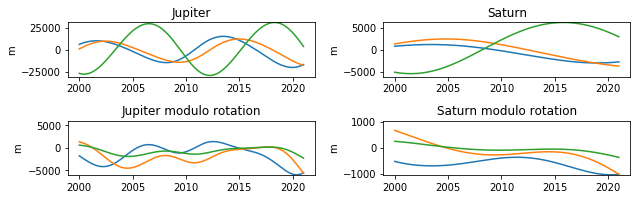

In [33]:
compare56(bsp421, bsp430)

## Compare Earth - Sun and Sun - SSB time series (paper figure 2)

Show that Earth-to-Sun is consistent at 10-m level, after accounting for overall rotation (and rotation rate on z axis). We'll limit plots to the span covered by the observations used for the older SSE:

* DE421: data until 2007
* DE430: until 2013
* DE435: until 2015
* DE436: until 2016

In [34]:
def compareEarthtoSun(bsp1, bsp2, yr1=1997, yr2=2007):
    jdates = np.linspace(ephem.julian_date(f'{yr1}/1/1'),ephem.julian_date(f'{yr2}/12/31'),2000)
    
    pp.subplot(3,1,1); plotdiff(310, jdates, bsp1, bsp2); pp.title("Difference")
    pp.subplot(3,1,2); plotdiff(310, jdates, bsp1, bsp2, dorotate=True); pp.title("Minus rotation")
    pp.subplot(3,1,3); plotdiff(310, jdates, bsp1, bsp2, dorotate=True, dotrend=True, ecliptic=True); pp.title("Minus rate")

    pp.tight_layout()

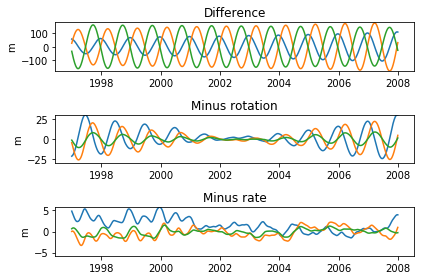

In [35]:
compareEarthtoSun(bsp421, bsp436, 1997, 2007)

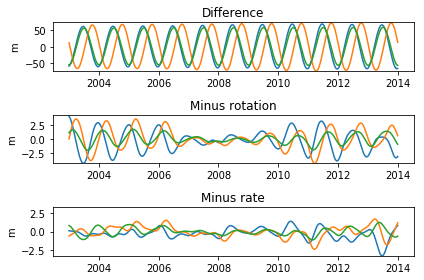

In [36]:
compareEarthtoSun(bsp430, bsp436, 2003, 2013)

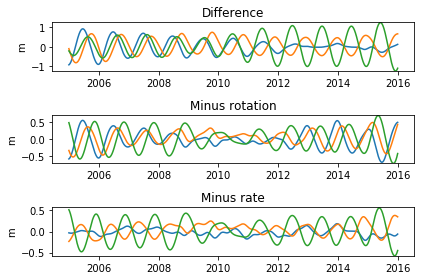

In [37]:
compareEarthtoSun(bsp435, bsp436, 2005, 2015)

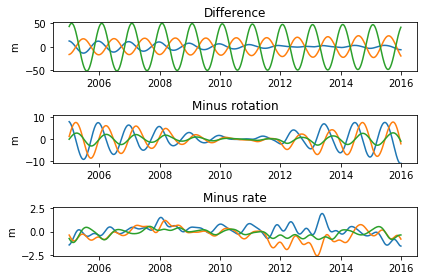

In [38]:
compareEarthtoSun(bsp438, bsp436, 2005, 2015)

Earth - Sun figure for paper.

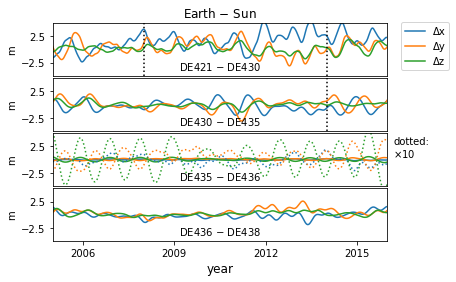

In [39]:
pp.figure(figsize=(6,4))

textx = 2005 + 11/2

jdates = np.linspace(ephem.julian_date('2005/1/1'),ephem.julian_date('2015/12/31'),2000)

pp.subplot(4,1,1)
plotdiff(310, jdates, bsp421, bsp430, dorotate=True, dotrend=True, ecliptic=True)
pp.axis(xmin=2005,xmax=2016,ymin=-5,ymax=5); pp.xticks([]); pp.yticks([-2.5,2.5])
pp.text(textx,-4,'DE421 $-$ DE430',ha='center')
pp.legend(['Δx','Δy','Δz'], bbox_to_anchor=(1.2, 1.12))
pp.axvline(2008,c='k',ls=':'); pp.axvline(2014,c='k',ls=':')
pp.title('Earth $-$ Sun')

pp.subplot(4,1,2)
plotdiff(310, jdates, bsp430, bsp435, dorotate=True, dotrend=True, ecliptic=True)
pp.axis(xmin=2005,xmax=2016,ymin=-5,ymax=5); pp.xticks([]); pp.yticks([-2.5,2.5])
pp.text(textx,-4,'DE430 $-$ DE435',ha='center')
pp.axvline(2014,c='k',ls=':')

pp.subplot(4,1,3)
plotdiff(310, jdates, bsp435, bsp436, dorotate=True, dotrend=True, ecliptic=True)
plotdiff(310, jdates, bsp435, bsp436, dorotate=True, dotrend=True, ecliptic=True, massratio=10, ls=':')
pp.axis(xmin=2005,xmax=2016,ymin=-5,ymax=5); pp.xticks([]); pp.yticks([-2.5,2.5])
pp.text(textx,-4,'DE435 $-$ DE436',ha='center')
pp.text(2016.2,3,'dotted:')
pp.text(2016.2,0.5,'$\\times 10$')
# pp.axvline(2016)

pp.subplot(4,1,4)
plotdiff(310, jdates, bsp436, bsp438, dorotate=True, dotrend=True, ecliptic=True)
pp.axis(xmin=2005,xmax=2016,ymin=-5,ymax=5); pp.xticks([2006,2009,2012,2015]); pp.yticks([-2.5,2.5])
pp.text(textx,-4,'DE436 $-$ DE438',ha='center')
pp.xlabel('year', fontsize=12)
# pp.axvline(2016)

# note subplots_adjust is not available in older matplotlib versions
pp.subplots_adjust(hspace=0.05)
# pp.tight_layout()

# pp.savefig('EarthSunDiff.pdf',bbox_inches='tight')

Sun - SSB figure for paper.

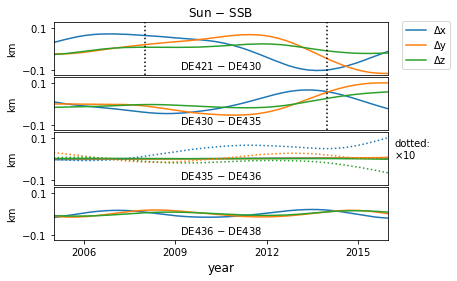

In [40]:
pp.figure(figsize=(6,4))

textx = 2005 + 11/2
yminymax = 125
ytick = 100
ytext = -100
ytickt = ['$-0.1$','$0.1$']

jdates = np.linspace(ephem.julian_date('2005/1/1'),ephem.julian_date('2015/12/31'),2000)

pp.subplot(4,1,1)
plotdiff(0, jdates, bsp421, bsp430, dorotate=True, demean=True, ecliptic=True)
pp.axis(xmin=2005,xmax=2016,ymin=-yminymax,ymax=yminymax)
pp.xticks([]); pp.yticks([-ytick,ytick],ytickt); pp.ylabel('km')
pp.text(textx,ytext,'DE421 $-$ DE430',ha='center')
pp.legend(['Δx','Δy','Δz'], bbox_to_anchor=(1.2, 1.12))
pp.axvline(2008,c='k',ls=':'); pp.axvline(2014,c='k',ls=':')
pp.title('Sun $-$ SSB')

pp.subplot(4,1,2)
plotdiff(0, jdates, bsp430, bsp435, dorotate=True, demean=True, ecliptic=True)
pp.axis(xmin=2005,xmax=2016,ymin=-yminymax,ymax=yminymax)
pp.xticks([]); pp.yticks([-ytick,ytick],ytickt); pp.ylabel('km')
pp.text(textx,ytext,'DE430 $-$ DE435',ha='center')
pp.axvline(2014,c='k',ls=':')

pp.subplot(4,1,3)
plotdiff(0, jdates, bsp435, bsp436, dorotate=True, demean=True, ecliptic=True)
plotdiff(0, jdates, bsp435, bsp436, dorotate=True, dotrend=True, ecliptic=True, massratio=10, ls=':')
pp.axis(xmin=2005,xmax=2016,ymin=-yminymax,ymax=yminymax)
pp.xticks([]); pp.yticks([-ytick,ytick],ytickt); pp.ylabel('km')
pp.text(textx,ytext,'DE435 $-$ DE436',ha='center')
pp.text(2016.2,60,'dotted:')
pp.text(2016.2,0,'$\\times 10$')
# pp.axvline(2016)

pp.subplot(4,1,4)
# plotdiff(0, jdates, bsp436, bsp438, dorotate=True, demean=True, ecliptic=True, massratio=10, ls=':')
plotdiff(0, jdates, bsp436, bsp438, dorotate=True, demean=True, ecliptic=True)
pp.axis(xmin=2005,xmax=2016,ymin=-yminymax,ymax=yminymax)
pp.xticks([2006,2009,2012,2015]); pp.yticks([-ytick,ytick],ytickt); pp.ylabel('km')
pp.text(textx,ytext,'DE436 $-$ DE438',ha='center')
pp.xlabel('year', fontsize=12)
# pp.axvline(2016)

# note subplots_adjust is not available in older matplotlib versions
pp.subplots_adjust(hspace=0.05)
# pp.tight_layout()

# pp.savefig('SunSSBDiff.pdf',bbox_inches='tight')

## Compare Roemer delays (paper figure 3)


Make a hundred random pulsar directions... set the seed so they're always the same.

In [41]:
random.seed(42)
ks = [randk() for k in range(100)]

Roemer delay differences (after subtraction): figure 3 of paper.

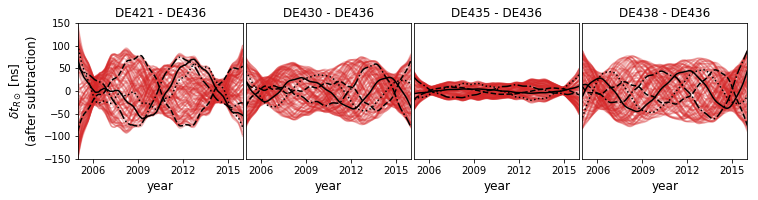

In [42]:
jdates10 = np.linspace(ephem.julian_date('2005/1/1'),ephem.julian_date('2015/12/31'),2000)

pp.figure(figsize=(12,2.5))

pp.subplot(1,4,1)
plotroemer(0, jdates10, bsp421, bsp436, ks, yrange=150)
pp.title('DE421 - DE436'); pp.xticks([2006,2009,2012,2015]); pp.axis(xmin=2005,xmax=2016)
pp.ylabel('$\delta t_{R\odot}$ [ns]\n(after subtraction)', fontsize=12)
pp.xlabel('year', fontsize=12)

pp.subplot(1,4,2)
plotroemer(0, jdates10, bsp430, bsp436, ks, yrange=150)
pp.title('DE430 - DE436'); pp.xticks([2006,2009,2012,2015]); pp.axis(xmin=2005,xmax=2016); pp.yticks([]); pp.ylabel('')
pp.xlabel('year', fontsize=12)

pp.subplot(1,4,3)
plotroemer(0, jdates10, bsp435, bsp436, ks, yrange=150)
pp.title('DE435 - DE436'); pp.xticks([2006,2009,2012,2015]); pp.axis(xmin=2005,xmax=2016); pp.yticks([]); pp.ylabel('')
pp.xlabel('year', fontsize=12)

pp.subplot(1,4,4)
plotroemer(0, jdates10, bsp438, bsp436, ks, yrange=150)
pp.title('DE438 - DE436'); pp.xticks([2006,2009,2012,2015]); pp.axis(xmin=2005,xmax=2016); pp.yticks([]); pp.ylabel('')
pp.xlabel('year', fontsize=12)

# note subplots_adjust is not available in older matplotlib versions
pp.subplots_adjust(wspace=0.02)
# pp.tight_layout()

# pp.savefig('roemerdiff.pdf',bbox_inches='tight')

For completeness, plot all pairs.

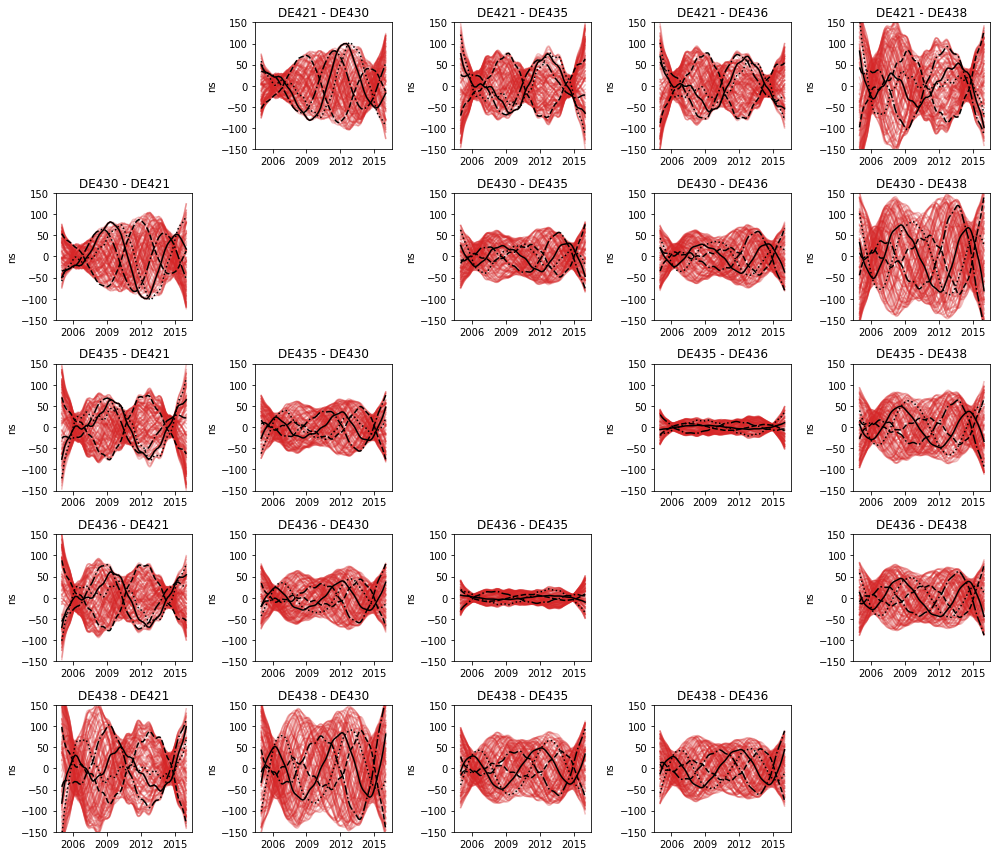

In [43]:
pp.figure(figsize=(14,12))

names = ['DE421','DE430','DE435','DE436','DE438']

for i, bsp1 in enumerate([bsp421,bsp430,bsp435,bsp436,bsp438]):
    for j, bsp2 in enumerate([bsp421,bsp430,bsp435,bsp436,bsp438]):       
        if i == j:
            continue
            
        pp.subplot(5,5,5*i+j+1)
        plotroemer(0, jdates10, bsp1, bsp2, ks, yrange=150)
        pp.title(f'{names[i]} - {names[j]}'); pp.xticks([2006,2009,2012,2015])

pp.tight_layout()

## Make quasi-Keplerian partials

### Code to generate quasi-Keplerian orbits

From http://ssd.jpl.nasa.gov: Keplerian elements and their rates, with respect to the mean ecliptic and equinox of J2000, valid for the time-interval 1800 AD - 2050 AD.

                   a              e               I                L            long.peri.      long.node.
               AU, AU/Cy     rad, rad/Cy     deg, deg/Cy      deg, deg/Cy      deg, deg/Cy     deg, deg/Cy
    -----------------------------------------------------------------------------------------------------------
    Mercury   0.38709927      0.20563593      7.00497902      252.25032350     77.45779628     48.33076593
              0.00000037      0.00001906     -0.00594749   149472.67411175      0.16047689     -0.12534081
    Venus     0.72333566      0.00677672      3.39467605      181.97909950    131.60246718     76.67984255
              0.00000390     -0.00004107     -0.00078890    58517.81538729      0.00268329     -0.27769418
    EM Bary   1.00000261      0.01671123     -0.00001531      100.46457166    102.93768193      0.0
              0.00000562     -0.00004392     -0.01294668    35999.37244981      0.32327364      0.0
    Mars      1.52371034      0.09339410      1.84969142       -4.55343205    -23.94362959     49.55953891
              0.00001847      0.00007882     -0.00813131    19140.30268499      0.44441088     -0.29257343
    Jupiter   5.20288700      0.04838624      1.30439695       34.39644051     14.72847983    100.47390909
             -0.00011607     -0.00013253     -0.00183714     3034.74612775      0.21252668      0.20469106
    Saturn    9.53667594      0.05386179      2.48599187       49.95424423     92.59887831    113.66242448
             -0.00125060     -0.00050991      0.00193609     1222.49362201     -0.41897216     -0.28867794
    Uranus   19.18916464      0.04725744      0.77263783      313.23810451    170.95427630     74.01692503
             -0.00196176     -0.00004397     -0.00242939      428.48202785      0.40805281      0.04240589
    Neptune  30.06992276      0.00859048      1.77004347      -55.12002969     44.96476227    131.78422574
              0.00026291      0.00005105      0.00035372      218.45945325     -0.32241464     -0.00508664
    Pluto    39.48211675      0.24882730     17.14001206      238.92903833    224.06891629    110.30393684    
             -0.00031596      0.00005170      0.00004818      145.20780515     -0.04062942     -0.01183482

The class `planet` solves Keplerian equations and returns ecliptic or equatorial orbits for a JD array of times. The subclasses `jupiter` and `saturn` initialize `planet` with values from the table above. The orbit methods can be called with perturbations (`x`) to the elements (if `len(x) == 6`) or to the elements and their rates (if `len(x) == 12`).

The business with the Boolean `bug` (also below in `planetpartials`) refers to the possibility of reproducing an early buggy version of the partials.

Code adapted from http://www.paulgriffiths.net/program/python/srcs/pyastrosrc.html

In [44]:
def kepler(m_anom, eccentricity):
    """Solves Kepler's equation for the eccentric anomaly using Newton's method.

    Arguments: m_anom                        -- mean anomaly in radians
               eccentricity                  -- eccentricity of the ellipse
    Returns:   eccentric anomaly in radians.
    """

    desired_accuracy = 1e-6
    e_anom = m_anom.copy()

    while True:
        diff = e_anom - eccentricity * np.sin(e_anom) - m_anom
        e_anom -= diff / (1 - eccentricity * np.cos(e_anom))
        
        if np.all(abs(diff) <= desired_accuracy):
            break
            
    return e_anom


class planet(object):
    J2000 = 2451545.0
    AU = 149597870700
    cmsec = 299792458
    
    def __init__(self, bug=False):
        self.bug = bug
        
        if bug:
            self.p = np.ones(6)
            self.r = np.ones(6)
                
    def helio_ecl_coords(self, julian_date, x=np.zeros(6,'d')):
        """Returns a len(julian_date) x 3 numpy array containing the
        heliocentric ecliptic rectangular coordinates of the planet,
        with fractional perturbation x[6]."""

        # Step 1: get Keplerian elements
        jdc = (julian_date - self.J2000) / 36525.0
        
        if self.bug:
            oea, oee, oei, oel, oew, oeo = ((self.p + x[:6]) * self.el +
                                            (self.r + (x[6:] if len(x) > 6 else 0)) * self.dl * jdc[:,np.newaxis]).T
        else:
            oea, oee, oei, oel, oew, oeo = ((self.el + x[:6]) +
                                            (self.dl + (x[6:] if len(x) > 6 else 0)) * jdc[:,np.newaxis]).T

        oei, oel, oew, oeo = map(np.radians, [oei, oel, oew, oeo])
        
        # Step 2: calculate argument of perihelion and mean anomaly

        arp = oew - oeo
        m_anom = oel - oew
        
        # Step 3: obtain eccentric anomaly by solving Kepler's equation M = E - e* sin E
        #         note that cfr. Standish we are working in radians
        
        e_anom = kepler(m_anom, oee)
        
        # Step 4: Compute heliocentric coordinates in the orbital plane

        xhc = oea * (np.cos(e_anom) - oee)
        yhc = oea * np.sqrt(1 - oee ** 2) * np.sin(e_anom)
        self._rhc = np.hypot(xhc, yhc)

        # Step 5: compute ecliptic coordinates in J2000 ecliptic plane

        xec = (( np.cos(arp) * np.cos(oeo) - np.sin(arp) * np.sin(oeo) * np.cos(oei)) * xhc +
               (-np.sin(arp) * np.cos(oeo) - np.cos(arp) * np.sin(oeo) * np.cos(oei)) * yhc)
        yec = (( np.cos(arp) * np.sin(oeo) + np.sin(arp) * np.cos(oeo) * np.cos(oei)) * xhc +
               (-np.sin(arp) * np.sin(oeo) + np.cos(arp) * np.cos(oeo) * np.cos(oei)) * yhc)
        zec = np.sin(arp) * np.sin(oei) * xhc + np.cos(arp) * np.sin(oei) * yhc

        # return position in seconds
        return np.array([xec, yec, zec]).T * (self.AU / self.cmsec)

    def helio_eq_coords(self, julian_date, x=np.zeros(6,'d')):
        """Returns a len(julian_date) x 3 numpy array containing the
        heliocentric equatorial rectangular coordinates of the planet,
        with fractional perturbation x[6]."""

        return ecl2eq_vec(self.helio_ecl_coords(julian_date,x))

    
class jupiter(planet):
    def __init__(self, *args, **kwargs):
        super(jupiter, self).__init__(*args, **kwargs)
        
        self.el = np.array([5.20288700,0.04838624,1.30439695,34.39644051,14.72847983,100.47390909])
        self.dl = np.array([-0.00011607,-0.00013253,-0.00183714,3034.74612775,0.21252668,0.20469106])

        
class saturn(planet):
    def __init__(self, *args, **kwargs):
        super(saturn, self).__init__(*args, **kwargs)
                
        self.el = np.array([9.53667594,0.05386179,2.48599187,49.95424423,92.59887831,113.66242448])
        self.dl = np.array([-0.00125060,-0.00050991,0.00193609,1222.49362201,-0.41897216,-0.28867794])

### Check: Jupiter's orbit against DE436

In [45]:
# our standard 21-year span
jdates = np.linspace(ephem.julian_date('2000/1/1'),ephem.julian_date('2020/12/31'),2000)
dates  = jdates - 2400000.5

In [46]:
jup = jupiter()

In [47]:
jorb_kepler = jup.helio_eq_coords(jdates)
jorb_eph436, _ = getplanet(5, jdates, bsp436)

The Keplerian orbits match DE436 approximately.

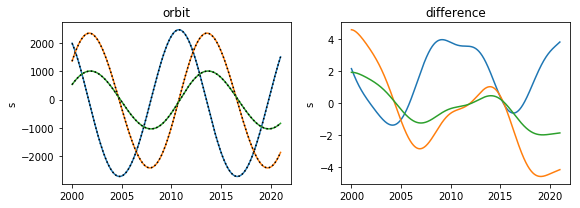

In [48]:
pp.figure(figsize=(12,3))

tyr = 1960 + (jdates - 2436934.5)/365.25

pp.subplot(1,3,1)
for i in range(3):
    pp.plot(tyr, jorb_kepler[:,i], f'C{i}')
    pp.plot(tyr, jorb_eph436[:,i], f'k:')
pp.title('orbit'); pp.ylabel('s')
    
pp.subplot(1,3,2)
for i in range(3):
    pp.plot(tyr, jorb_kepler[:,i] - jorb_eph436[:,i], f'C{i}')
pp.title('difference'); pp.ylabel('s');

pp.tight_layout()

### Improve orbit fit by searching over quasi-Keplerian parameters

We use `scipy.optimize.fmin`, which requires the function to be minimized (the L2 norm of the 3D difference between orbits) and a starting point. We all fitting elements only or elements and rates.

In [49]:
def planetfit(planet, orbitref, rates=False):
    # perturbed Eulerian orbits
    def model(x):
        return planet.helio_eq_coords(jdates, x)

    # we minimize the L2 norm of the difference
    def minf(x):
        d = orbitref - model(x)
        return math.sqrt(np.sum(d**2) / d.shape[0])
    
    # optimize three times to be safe
    x = [0] * (12 if rates else 6)
    for i in range(3):
        x = so.fmin(minf, x, xtol=1e-10, ftol=1e-9,
                    maxfun=10000, maxiter=10000, disp=(i==2))
        
    print('x = {}, res = {}'.format(x, minf(x)))
    
    return x, model(x)

In [50]:
jx_optim, jorb_optim = planetfit(jup, jorb_eph436)

Optimization terminated successfully.
         Current function value: 1.510357
         Iterations: 194
         Function evaluations: 385
x = [-0.00531362  0.00041559 -0.00050477 -0.0195762  -0.3401888   0.01499085], res = 1.510357246774164


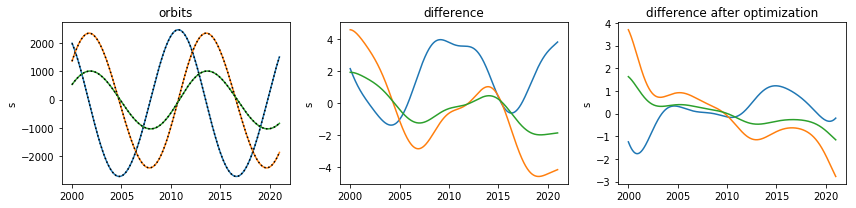

In [51]:
pp.figure(figsize=(12,3))

tyr = 1960 + (jdates - 2436934.5)/365.25

pp.subplot(1,3,1)
for i in range(3):
    pp.plot(tyr, jorb_kepler[:,i], f'C{i}')
    pp.plot(tyr, jorb_eph436[:,i], f'k:')
pp.title('orbits'); pp.ylabel('s')
    
pp.subplot(1,3,2)
for i in range(3):
    pp.plot(tyr, jorb_kepler[:,i] - jorb_eph436[:,i], f'C{i}')
pp.title('difference'); pp.ylabel('s')
    
pp.subplot(1,3,3)
for i in range(3):
    pp.plot(tyr, jorb_optim[:,i] - jorb_eph436[:,i], f'C{i}')
pp.title('difference after optimization'); pp.ylabel('s');

pp.tight_layout()

Now include rates. This takes a little while.

In [52]:
jx_optim_rates, jorb_optim_rates = planetfit(jup, jorb_eph436, rates=True)

Optimization terminated successfully.
         Current function value: 0.409359
         Iterations: 409
         Function evaluations: 808
x = [-5.15900119e-03  4.60913347e-04 -1.63633750e-04 -4.51036010e-02
  3.91428544e-01  2.13395073e-02  2.84135025e-03  7.42329015e-05
 -3.23939227e-03  2.89889584e-01 -7.38964790e+00 -5.89572823e-02], res = 0.4093585341230143


Much better!

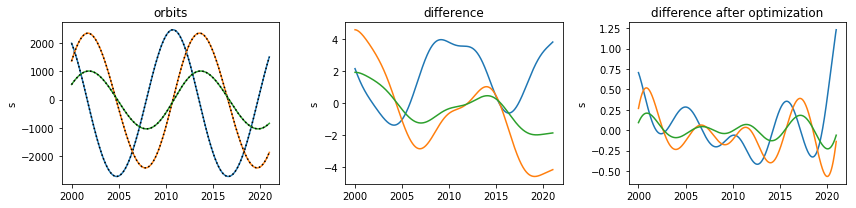

In [53]:
pp.figure(figsize=(12,3))

tyr = 1960 + (jdates - 2436934.5)/365.25

pp.subplot(1,3,1)
for i in range(3):
    pp.plot(tyr, jorb_kepler[:,i], f'C{i}')
    pp.plot(tyr, jorb_eph436[:,i], f'k:')
pp.title('orbits'); pp.ylabel('s')

pp.subplot(1,3,2)
for i in range(3):
    pp.plot(tyr, jorb_kepler[:,i] - jorb_eph436[:,i], f'C{i}')
pp.title('difference'); pp.ylabel('s')

pp.subplot(1,3,3)
for i in range(3):
    pp.plot(tyr, jorb_optim_rates[:,i] - jorb_eph436[:,i], f'C{i}')
pp.title('difference after optimization'); pp.ylabel('s')

pp.tight_layout()

### Make the partials and plot them

Make partials with respect to elements by way of simple finite differences. The partials are returns in a 6 x 2000 x 3 array, where dimensions correspond to partial index, time, and (x,y,z).

In [54]:
def planetpartials(planet, jdates, solution, bug=False):
    ret = np.zeros((6, len(jdates), 3), 'd')

    if bug:
        assert hasattr(planet, 'p')
        planet.p = np.zeros(6, 'd')
    
    for i in range(6):
        dx = np.zeros(6,'d')
        
        dx[i] = 1e-6; orbplus = planet.helio_eq_coords(jdates, solution + dx)
        dx[i] = -1e-6; orbminus = planet.helio_eq_coords(jdates, solution + dx)
        
        ret[i,:,:] = (orbplus - orbminus) / (2*abs(dx[i]))
    
    if bug:
        planet.p = np.ones(6,'d')
    
    return ret

In [55]:
jup = jupiter(bug=False)

In [56]:
jpartials = planetpartials(jup, jdates, jx_optim, bug=False)

Get a sense of partials accuracy by comparing them on optimized and nonoptimized orbits. We get < 1% corrections.

In [57]:
djpartials = planetpartials(jup, jdates, jx_optim) - planetpartials(jup, jdates, np.zeros(6,'d'))

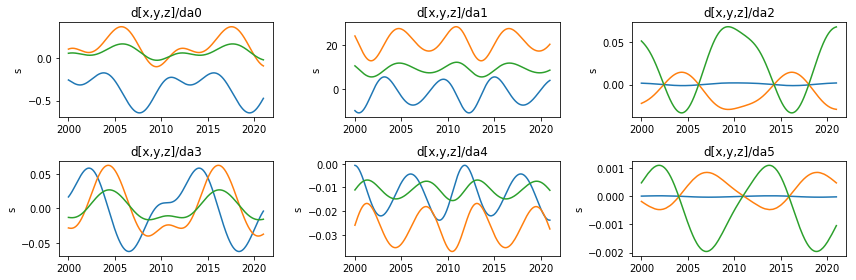

In [58]:
pp.figure(figsize=(12,4))

mult = [1,1,1,1,1,1]

for j in range(6):
    pp.subplot(2,3,j+1)

    for i in range(3):
        pp.plot(tyr, mult[j]*djpartials[j,:,i], f'C{i}')
   
    pp.title(f'd[x,y,z]/da{j}'); pp.ylabel('s')

pp.tight_layout()

Figure 4 for paper.

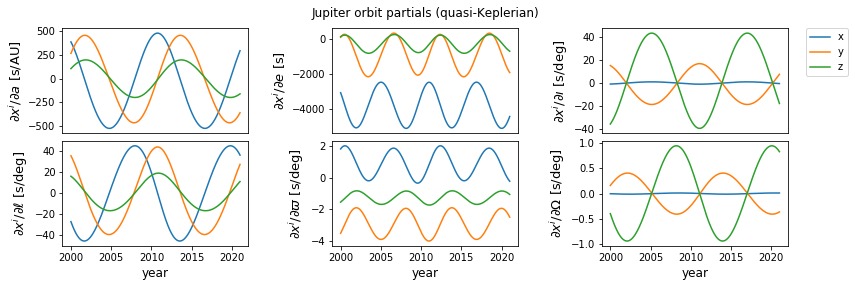

In [59]:
pp.figure(figsize=(13,4))

tyr = 1960 + (jdates - 2436934.5)/365.25

mult = [1,1,1,1,1,1]

for j in range(6):
    pp.subplot(2,3,j+1)

    for i in range(3):
        pp.plot(tyr, mult[j]*jpartials[j,:,i], f'C{i}')
    
    pp.ylabel([r'$\partial x^i/\partial a$ [s/AU]',
               r'$\partial x^i/\partial e$ [s]',
               r'$\partial x^i/\partial \i$ [s/deg]',
               r'$\partial x^i/\partial \ell$ [s/deg]',
               r'$\partial x^i/\partial \varpi$ [s/deg]',
               r'$\partial x^i/\partial \Omega$ [s/deg]'][j], fontsize=13)
    
    if j < 3:
        pp.xticks([])
    else:
        pp.xlabel('year', fontsize=12)
    
    if j == 1:
        pp.title('Jupiter orbit partials (quasi-Keplerian)')
        pp.gca().title.set_position([.5, 1.05])
    elif j == 2:
        pp.legend(['x','y','z'],bbox_to_anchor=(1.35, 1.05))
    
pp.subplots_adjust(wspace=0.45, hspace=0.075)
# pp.tight_layout()

try:
    pp.gcf().align_ylabels()
except:
    pass

# pp.savefig('JupiterPartials.pdf')

### Make SVD basis for partials

To make an SVD basis for the partials, we flatten the 6 x 2000 x 3 array to 6 x 6000, interleaving (x,y,z). We return the basis (again 6 x 2000 x 3) and a conversion matrix that will be used later to remap SVD correction vectors $b^\mu$ to standard-element correction vectors $a^\mu$.

Here the decomposition is $P = U S V^\dagger$, so $a P = (b U S) V^\dagger$ and $a = b U S$ (right-multiplied).

In [60]:
def makesvd(jpartials):
    U, S, Vh = sla.svd(jpartials.reshape((6, 3*jpartials.shape[1])), full_matrices=False)
    jsvd = Vh.copy().reshape((6,jpartials.shape[1],3))

    # equivalent, but not as smart: Mconv = np.array([[U[i,j] * S[j] for j in range(6)] for i in range(6)])
    Mconv = U @ np.diag(S)
    
    return jsvd, Mconv

In [61]:
jsvd, Mconv = makesvd(jpartials)

Save for Enterprise.

In [62]:
# np.save('data/jupiter_orbitpartials/jupiter-orbel-v2-mjd.npy', jdates - 2400000.5)
# np.save('data/jupiter_orbitpartials/jupiter-orbel-v2-xyz.npy', jpartials)
# np.save('data/jupiter_orbitpartials/jupiter-orbel-v2-xyz-svd.npy', jsvd)
# np.save('data/jupiter_orbitpartials/jupiter-orbel-v2-Mconv.npy', Mconv)

Figure 4 of paper.

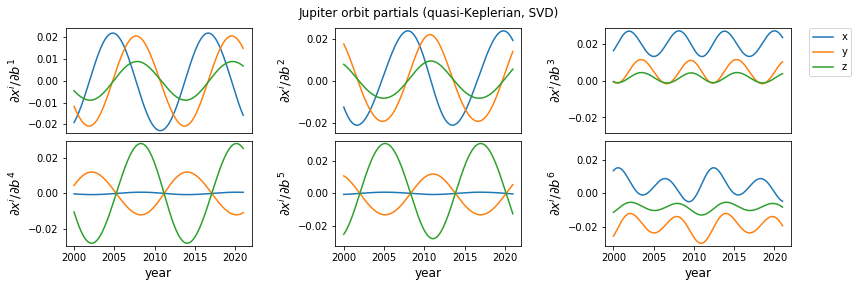

In [63]:
pp.figure(figsize=(13,4))

tyr = 1960 + (jdates - 2436934.5)/365.25

remap = [-1,2,0,5,3,4]

for jj in range(6):
    pp.subplot(2,3,jj+1)

    j = abs(remap[jj])
    
    ymax = []
    for i in range(3):
        pp.plot(tyr, (-1 if remap[jj] < 0 else 1) * jsvd[j,:,i], f'C{i}')
        ymax.append([np.max(jsvd[j,:,i]),np.max(-jsvd[j,:,i])])
    
    ymax = np.max(ymax) * 1.05
    pp.axis(ymin=-ymax,ymax=ymax)
    
    pp.ylabel(r'$\partial x^i/\partial b^%i$' % (jj+1), fontsize=13)

    if j < 3:
        pp.xticks([])
    else:
        pp.xlabel('year', fontsize=12)
    
    if jj == 1:
        pp.title('Jupiter orbit partials (quasi-Keplerian, SVD)')
        pp.gca().title.set_position([.5, 1.05])
    elif jj == 2:
        pp.legend(['x','y','z'],bbox_to_anchor=(1.35, 1.05))
   
    pp.axis(ymin=-ymax,ymax=ymax)

pp.subplots_adjust(wspace=0.45, hspace=0.075)
# pp.tight_layout()

try:
    pp.gcf().align_ylabels()
except:
    pass
    
# pp.savefig('JupiterPartialsSVD.pdf')

### Compare quasi-Keplerian partials with an earlier buggy version

(This section is included for historical completeness, but it is not needed to reproduce the results of our paper.)

As mentioned earlier, an old version of this code, used to produce partials for Enterprise, suffered from a bug that reset the Jupiter orbit settings, so the resulting perturbations had the wrong phases. Here we show that the two bases span the same space of Roemer delays, so the early Monte Carlo runs nevertheless produced correct GW posteriors.

In [64]:
jup_bug = jupiter(bug=True)
jx_optim_bug, jorb_optim_bug = planetfit(jup_bug, jorb_eph436)

jpartials_bug = planetpartials(jup_bug, jdates, jx_optim_bug, bug=True)

Optimization terminated successfully.
         Current function value: 1.510357
         Iterations: 185
         Function evaluations: 332
x = [-0.00102128  0.00858907 -0.00038698 -0.00056913 -0.02309734  0.00014921], res = 1.5103572467741464


These are the early buggy saved files.

In [65]:
jupiter_orbel_xyz = np.load('../data/jupiter_orbitpartials/jupiter-orbel-xyz.npy')

Compare correct and buggy partials vs file... indeed, our representation of the bug reproduces earlier results.

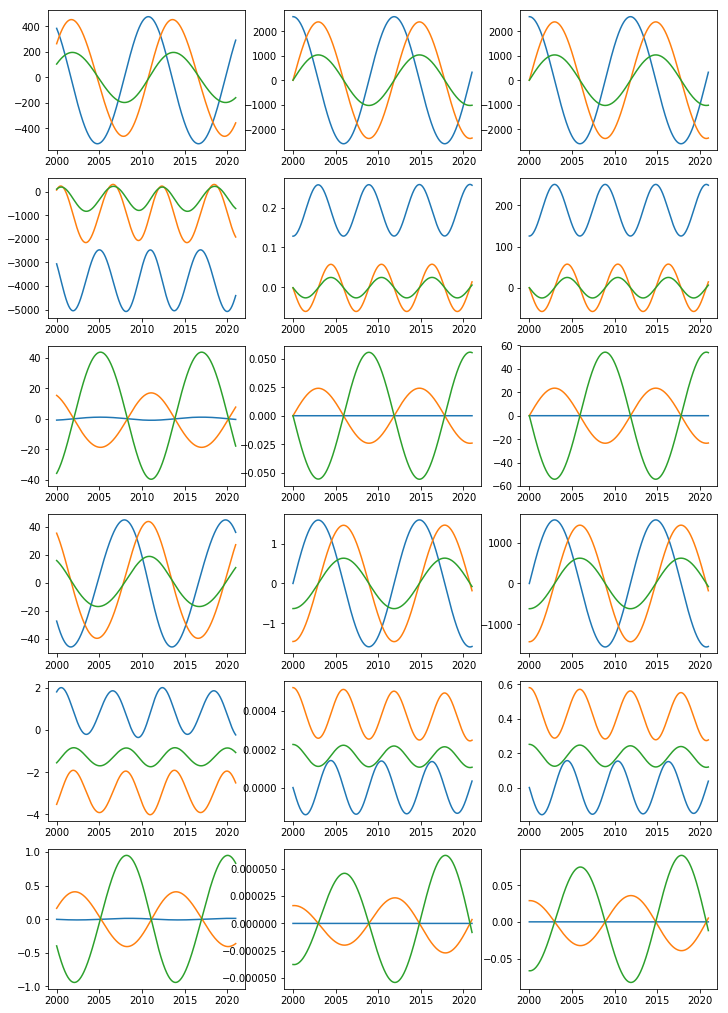

In [66]:
doecliptic = False

d = 2000 + (dates - dates[0])/365.25
tyr = 1960 + (jdates - 2436934.5)/365.25

pp.figure(figsize=(12,3*6))

for j in range(6):
    o1, o2, o3 = jpartials[j,:,:], jpartials_bug[j,:,:], jupiter_orbel_xyz[j,:,:]
    
    if doecliptic:
        o1, o2 = eq2ecl_vec(o1), eq2ecl_vec(o2)
    
    pp.subplot(6,3,j*3+1)
    for i in range(3):
        pp.plot(d, o1[:,i], f'C{i}')
        # pp.plot(d-5, o2[:,i], f'C{i}--')

    pp.subplot(6,3,j*3+2)
    for i in range(3):
        pp.plot(d, o2[:,i])
        
    pp.subplot(6,3,j*3+3)
    for i in range(3):
        pp.plot(d, o3[:,i])

Compare SVD partials with and without bug.

In [67]:
U, S, Vh = sla.svd(jpartials_bug.reshape((6, 3*jpartials_bug.shape[1])), full_matrices=False)
jsvd_bug = Vh.copy().reshape((6,jpartials_bug.shape[1],3))

OK, so we will examine the reconstruction of a "new" (correct) orbital perturbation vector in terms of the buggy basis.

In [68]:
def decomp(v, basis):
    return sum(np.sum(v * basis[i,...])*basis[i,...] for i in range(6))

Three of the basis vectors are reconstructed exactly; one to 1%; one to 10%.

In [69]:
for i in range(6):
    print(np.sum(decomp(jsvd[i,:,:], jsvd_bug) * jsvd[i,:,:]))

0.8866060701079358
0.9998244928203185
0.9989782442058093
0.9745421325493212
0.8826186647708811
0.9955386801532755


Things are even better for the reconstruction of a Roemer-projected perturbation in terms of the buggy projections.

In [70]:
def roemerize(series):
    roemer = series.copy()
    
    t = (jdates - jdates[0])/365.25
    
    y0 = xnorm(np.ones(len(roemer), 'd'))
    y1 = xnorm(np.linspace(0.0, 1.0, len(roemer)))
    y2 = xnorm(y1*y1)
    y3 = xnorm(np.sin(2*math.pi*t))
    y4 = xnorm(np.cos(2*math.pi*t))
    
    for y in orthonorm([y0, y1, y2, y3, y4]):
        roemer -= np.dot(roemer, y) * y
    
    return roemer

Indeed, the error in the buggy reconstruction is ~0.1%.

In [71]:
random.seed(42)
ks = [randk() for k in range(100)]

In [72]:
rs = np.array(orthonorm([roemerize(np.dot(jsvd[i,...],ks[5])) for i in range(6)]))
rs_bug = np.array(orthonorm([roemerize(np.dot(jsvd_bug[i,...],ks[5])) for i in range(6)]))

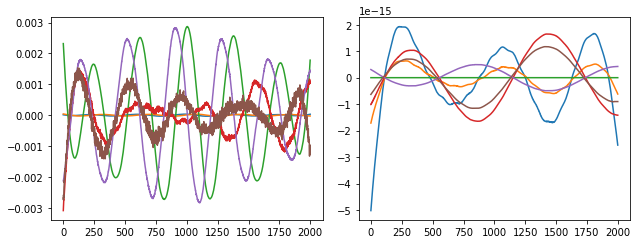

In [73]:
pp.figure(figsize=(9,3.5))

pp.subplot(1,2,1)
for ii in range(6):
    pp.plot(rs_bug[ii] - decomp(rs_bug[ii],rs))
    
pp.subplot(1,2,2)
for ii in range(6):
    pp.plot(rs_bug[ii] - decomp(rs_bug[ii],rs_bug))
    
pp.tight_layout()

Should we need it, the conversion matrix from buggy ($\delta b_i$, with vectors $w_i$) to correct ($\delta a_i$, with vectors $v_i$) coefficients is given by $\delta a_j = (\mathbf{v}_j \cdot \mathbf{w}_i) \delta b^i = C_{ji} \delta b^i$.

In [74]:
Cconv = np.array([[np.sum(jsvd[j,:,:] * jsvd_bug[i,:,:]) for i in range(6)] for j in range(6)])

### Make Saturn partials

Everything just as for Jupiter

In [75]:
sat = saturn()

sorb_eph436, _ = getplanet(6, jdates, bsp436)
sx_optim, sorb_optim = planetfit(sat, sorb_eph436)

spartials = planetpartials(sat, jdates, sx_optim, bug=False)

Optimization terminated successfully.
         Current function value: 2.254342
         Iterations: 227
         Function evaluations: 429
x = [ 5.22916050e-03  2.73358653e-04  5.55310967e-04  6.23104408e-02
 -5.38607818e-01 -2.25115224e-02], res = 2.25434191428601


In [76]:
sx_optim_rates, sorb_optim_rates = planetfit(sat, sorb_eph436, rates=True)

Optimization terminated successfully.
         Current function value: 0.464167
         Iterations: 446
         Function evaluations: 868
x = [ 5.26910968e-03  1.72603504e-04  5.99924739e-04  1.92425361e-01
  5.07390708e-01 -3.90911901e-02  1.89120506e-02 -3.05328687e-04
 -6.47622632e-04 -1.03523038e+00 -3.65218874e+00  1.47533035e-01], res = 0.46416666003248663


In [77]:
U, S, Vh = sla.svd(spartials.reshape((6, 3*spartials.shape[1])), full_matrices=False)
ssvd = Vh.copy().reshape((6,spartials.shape[1],3))

# Mconv = np.array([[U[i,j] * S[j] for j in range(6)] for i in range(6)])
Mconvs = U @ np.diag(S)

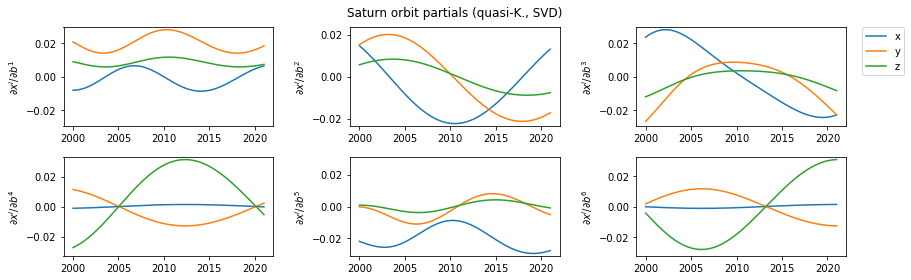

In [78]:
pp.figure(figsize=(12,4))

tyr = 1960 + (jdates - 2436934.5)/365.25

for j in range(6):
    pp.subplot(2,3,j+1)

    ymax = []
    for i in range(3):
        pp.plot(tyr, ssvd[j,:,i], f'C{i}')
        ymax.append([np.max(ssvd[j,:,i]),np.max(-ssvd[j,:,i])])
    
    ymax = np.max(ymax) * 1.05
    pp.axis(ymin=-ymax,ymax=ymax)
    
    pp.ylabel(r'$\partial x^i/\partial b^%i$' % (j+1))

    if j == 1:
        pp.title('Saturn orbit partials (quasi-K., SVD)')
        pp.gca().title.set_position([.5, 1.05])
    elif j == 2:
        pp.legend(['x','y','z'],bbox_to_anchor=(1.3, 1.05))
    
pp.tight_layout()

# pp.savefig('JupiterPartialsSVD.pdf')

In [79]:
# np.save('data/saturn_orbitpartials/saturn-orbel-v2-mjd.npy', jdates - 2400000.5)
# np.save('data/saturn_orbitpartials/saturn-orbel-v2-xyz.npy', spartials)
# np.save('data/saturn_orbitpartials/saturn-orbel-v2-xyz-svd.npy', ssvd)
# np.save('data/saturn_orbitpartials/saturn-orbel-v2-Mconv.npy', Mconvs)

## Make Set III partials

Here we make partials with respect to Brouwer and Clemence's "set III" orbital elements. These are useful because the JPL ephemeris gurus gave us covariance matrix for the Jupiter elements in these coordinates.

### Fortran code to makes partials

This code (provided by Bill Folkner) takes a mass parameter, an array of positions + velocities + (time - epoch) [in AU, AU/day, and days], and returns position and velocity partials with respect to the set III parameters. Since these are radians or dimensionless, the units of the partials are AU/rad and AU/day/rad.

You'll need a Fortran compiler, and possibly `pip install fortran-magic`.

In [80]:
%load_ext fortranmagic

/Users/vallis/anaconda3/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [81]:
%%fortran
      SUBROUTINE VCROSS(a, b, cross)
      REAL(8), DIMENSION(3), INTENT(IN) :: a, b
      REAL(8), DIMENSION(3), INTENT(OUT) :: cross

      cross(1) = a(2) * b(3) - a(3) * b(2)
      cross(2) = a(3) * b(1) - a(1) * b(3)
      cross(3) = a(1) * b(2) - a(2) * b(1)
      END SUBROUTINE VCROSS

      SUBROUTINE EMSMAG(R,SR)
      REAL(8), DIMENSION(3), INTENT(IN) :: R
      REAL(8), INTENT(OUT) :: SR
    
      SR = SQRT(R(1)*R(1) + R(2)*R(2) + R(3)*R(3))
      END SUBROUTINE EMSMAG
    
      SUBROUTINE EMSDOT(a, b, dot)
      REAL(8), DIMENSION(3), INTENT(IN) :: a, b
      REAL(8), INTENT(OUT) :: dot
            
      dot = a(1)*b(1) + a(2)*b(2) + a(3)*b(3)
      END SUBROUTINE EMSDOT
    
      SUBROUTINE VNORM(v, norm)
      REAL(8), DIMENSION(3), INTENT(INOUT) :: v
      REAL(8), INTENT(OUT) :: norm
            
      CALL EMSMAG(v, norm)
    
      DO 1 I=1,3
   1  v(I) = v(I) / norm
      END SUBROUTINE VNORM
    
      SUBROUTINE S3PAR6(RMU,R,PX)   

c SET III Formulation of Brouwer & Clemence (pg. 241)
c
c     S3PAR6(RMU,R,PX)
c
c                   d(x,y,z,x-dot,y-dot,z-dot)
c     computes PX = --------------------------
c                         d(set III)
c
c
c     where   setIII = DMWi, DPi, DQi, EDWi, DAi, DEi
c
c             RMU = GMsun + GMi
c
c             R = x, y, z, x-dot, y-dot, z-dot, t-t0
c
c     Note : t-t0 is time since epoch of partials
c
c     in  [ (au) and (au/day) / (radians) ]
c
c The formulation follows (Standish JPL IOM 314.6-629, 1985)

      IMPLICIT DOUBLE PRECISION (A-H,O-Z)
      REAL(8), INTENT(IN) :: RMU
      REAL(8), DIMENSION(7), INTENT(IN) :: R
      REAL(8), DIMENSION(6,6), INTENT(OUT) :: PX
            
      REAL(8), DIMENSION(3,3) :: PQR
      REAL(8), DIMENSION(8) :: W

      save

c     R = r X r-dot 

      CALL VCROSS(R,R(4),PQR(1,3))   


c     P = r-dot X h  -  mu * r-cap   (Danby, pg 122)

      CALL VCROSS(R(4),PQR(1,3),PQR(1,1))  

      CALL EMSMAG(R,SR)   
      DO 1 I=1,3  
   1  PQR(I,1)=PQR(I,1)-RMU*R(I)/SR 


c     Q = R X P

      CALL VCROSS(PQR(1,3),PQR(1,1),PQR(1,2))    


c Normalize P, Q, R

      DO 2 I=1,3  
   2  CALL VNORM(PQR(1,I),SH) 


c  Compute v**2, r r-dot, a, n, (1-ee), ee, e, ae(1-ee)

      CALL EMSDOT(R(4),R(4),VV) 
      CALL EMSDOT(R,R(4),RRD)   

      A=SR*RMU/(2.D0*RMU-SR*VV)     
      EN=DSQRT(RMU/A**3)
      PAR=SH*SH/(RMU*A) 
      EE=1.D0-PAR 
      E=DSQRT(EE) 
      AEPAR=A*E*PAR     

C  H adn K  (Brouwer & Clemence, pg. 237)

      CH=(SR-A*(1.D0+EE))/AEPAR     
      CK=(RRD/((A*EN)**2*E))*(1.D0+SR/(A*PAR))  

c  H-dot and K-dot

      CHD=RRD/(SR*AEPAR)
      CKD=(2.D0*(A-SR)+A*EE)/AEPAR  
C     
      FAC=-RMU/SR**3    

c  Load r, r-dot and r-dot-dot into W

      DO 3 I=1,3  
      W(I)=R(I)   
      W(I+3)=R(I+3)     
   3  W(I+6)=FAC*W(I)   

c  DP = P X r; DQ = Q X r; EDW = (- r-dot/n + R X r)/e

c  P X r, P X r-dot, Q X r, Q X r-dot, R X r and R X r-dot into PX

      DO 4 I=1,4,3
      DO 4 J=1,3  
   4  CALL VCROSS(PQR(1,J),R(I),PX(I,J+1)) 
   

      DO 5 I=1,6  

c  DMW = r-dot / n

      PX(I,1)=W(I+3)/EN 

c  DA = r - 3/2 t r-dot; r-dot - 3/2 t r-dot-dot - 3/2 r-dot

      PX(I,5)=W(I)-1.5D0*R(7)*W(I+3)

c  DE = H r + K r-dot, 
c          H r-dot + K r-dot-dot  +  h-dot r + K-dot r-dot

      PX(I,6)=CH*W(I)+CK*W(I+3)     

c  (finish the rest of EDW)

   5  PX(I,4)=(PX(I,4)-W(I+3)/EN)/E 


      DO 6 I=1,3  

c  (finish the last term of DA)

      PX(I+3,5)=PX(I+3,5)-1.5D0*W(I+3)    

c  (finish the last terms of DE)

   6  PX(I+3,6)=PX(I+3,6)+CHD*W(I)+CKD*W(I+3)   
              
      RETURN
      END

Make the orbits to feed to the Fortran code. We can use our quasi-Keplerian code or the SSEs directly.

In [82]:
J2000 = 2451545.0
AU = 149597870700
cmsec = 299792458

au_over_sec = cmsec / AU

def xxdot(jdates, equatorial=True, tref=2440400.5, planet=jupiter, x_optim=jx_optim_rates):
    getcoords = planet().helio_eq_coords if equatorial else planet().helio_ecl_coords
        
    # Jupiter orbit in AU
    x = au_over_sec * getcoords(jdates, x_optim)

    # Jupiter velocity in AU/day
    xdot = au_over_sec * (getcoords(jdates + 1, x_optim) - getcoords(jdates - 1, x_optim)) / 2
        
    # time since epoch of partials
    t = jdates - tref
    
    return np.hstack((x, xdot, t[:,np.newaxis]))

def xxdot_eph(jdates, equatorial=True, tref=2440400.5, planet=5, bsp=bsp436):
    assert equatorial

    pos, vel = getplanet(planet, jdates, bsp)
            
    # Jupiter orbit in AU
    x = au_over_sec * pos

    # Jupiter velocity in AU/day
    xdot = au_over_sec * vel * 86400
        
    # time since epoch of partials
    t = jdates - tref
    
    return np.hstack((x, xdot, t[:,np.newaxis]))

Mass parameter for Jupiter

In [83]:
GMsun_AUd = 1.32712442099e20 / (AU**3 / 86400**2) # m3s−2 -> AU3 d-2
GMjup_AUd = GMsun_AUd / 1.047348644e3

rmu = GMsun_AUd + GMjup_AUd

Put everything together.

In [84]:
def makesetIIIpartials(jdates, tref=2440400.5,
                       planet=jupiter, x_optim=jx_optim_rates, rmu=GMsun_AUd+GMjup_AUd):
    r = xxdot(jdates, equatorial=True, tref=tref, planet=planet, x_optim=x_optim)

    set3partials = np.zeros((6,r.shape[0],3))

    for k in range(r.shape[0]):
        set3partials[:,k,:] = s3par6(rmu, r[k,:])[:3,:6].T
        
    return set3partials

def makesetIIIpartials_eph(jdates, tref=2440400.5, planet=5, bsp=bsp436, rmu=GMsun_AUd+GMjup_AUd):
    r = xxdot_eph(jdates, equatorial=True, tref=tref, planet=planet, bsp=bsp)

    set3partials = np.zeros((6,r.shape[0],3))

    for k in range(r.shape[0]):
        set3partials[:,k,:] = s3par6(rmu, r[k,:])[:3,:6].T
        
    return set3partials

In [85]:
set3partials = makesetIIIpartials(jdates)

We get the same results also by running the computation in ecliptic coordinates, then converting

In [86]:
# r = xxdot(jdates, equatorial=False, tref=2440400.5)

# set3partials_ecl = np.zeros((6,r.shape[0],3))
# set3partials = np.zeros((6,r.shape[0],3))

# for k in range(r.shape[0]):
#     set3partials_ecl[:,k,:] = s3par6(rmu, r[k,:])[:3,:6].T
    
# for k in range(6):
#     set3partials[k,:,:] = ecl2eq_vec(set3partials_ecl[k,:,:])

Here they are! We need some remapping of coordinates so we can plot in logical order.

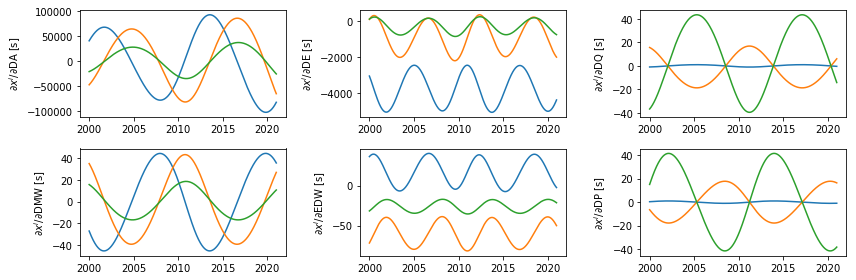

In [87]:
parind = {'DA': 4, 'DE': 5, 'DP': 1, 'DQ': 2, 'DMW': 0, 'EDW': 3}

pp.figure(figsize=(12,4))

tyr = 2000 + (jdates - jdates[0])/365.25
mult = [1,1,math.pi/180,math.pi/180,math.pi/180,math.pi/180]

for j, var in enumerate(['DA', 'DE', 'DQ', 'DMW', 'EDW', 'DP']):
    pp.subplot(2,3,j+1)

    for i in range(3):
        pp.plot(tyr, mult[j] * (AU/cmsec) * set3partials[parind[var],:,i], f'C{i}')
        
    pp.ylabel(r'$\partial x^i/\partial \mathrm{' + var + '}$ [s]')
        
pp.tight_layout()

Check against a few values from Bill Folkner.

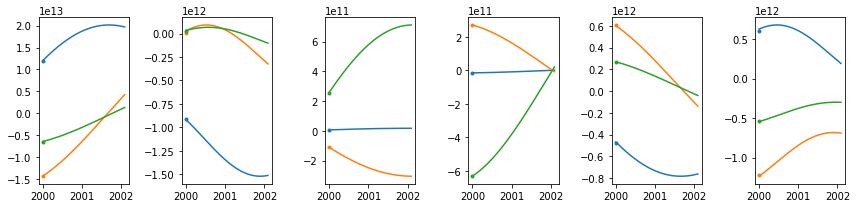

In [88]:
# checks provided by Bill Folkner (equatorial, in km/deg)

xyz = {'DA':  [ 1.20262807773396e+10,-1.43268663380316e+10,-6.43391905757151e+09],
       'DE':  [-9.11401212616218e+08, 1.03431995771853e+07, 2.66046657997218e+07],
       'DP':  [ 6.40787059136829e+06,-1.10614953336483e+08, 2.57569281635618e+08],
       'DQ':  [-1.52733213343214e+07, 2.70497680446158e+08,-6.31741799726461e+08],
       'DMW': [-4.73450349092525e+08, 6.09298914468547e+08, 2.72692531635397e+08],
       'EDW': [ 6.06449895432699e+08,-1.21734424415590e+09,-5.36536559398573e+08]}

pp.figure(figsize=(12,3))

for i, var in enumerate(parind.keys()):
    pp.subplot(1,6,i+1)
    
    for i in range(3):
        pp.plot(tyr[:200], AU * set3partials[parind[var],:200,i], f'C{i}')
        pp.plot(tyr[0], 1e3*xyz[var][i], f'C{i}.')
        
pp.tight_layout()

### Make SVD basis

Just as above for quasi-Keplerian.

In [89]:
bsvd, Mconvb = makesvd(set3partials)

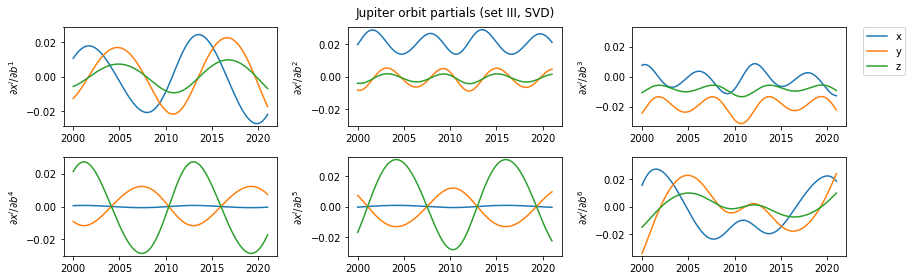

In [90]:
pp.figure(figsize=(12,4))

tyr = 1960 + (jdates - 2436934.5)/365.25

for j in range(6):
    pp.subplot(2,3,j+1)

    ymax = []
    for i in range(3):
        pp.plot(tyr, bsvd[j,:,i], f'C{i}')
        ymax.append([np.max(bsvd[j,:,i]),np.max(-bsvd[j,:,i])])
    
    ymax = np.max(ymax) * 1.05
    pp.axis(ymin=-ymax,ymax=ymax)
    
    pp.ylabel(r'$\partial x^i/\partial b^%i$' % (j+1))

    if j == 1:
        pp.title('Jupiter orbit partials (set III, SVD)')
        pp.gca().title.set_position([.5, 1.05])
    elif j == 2:
        pp.legend(['x','y','z'],bbox_to_anchor=(1.3, 1.05))
    
pp.tight_layout()

In [91]:
# np.save('data/setIII_partials/jupiter-setIII-mjd.npy',     jdates - 2400000.5)
# np.save('data/setIII_partials/jupiter-setIII-xyz.npy',     set3partials)
# np.save('data/setIII_partials/jupiter-setIII-xyz-svd.npy', bsvd)
# np.save('data/setIII_partials/jupiter-setIII-Mconv.npy',   Mconvb)

### Compare with quasi-Keplerian partials

The semimajor axis doesn't match because it's fundamentally different in the two formulations. In the quasi-Keplerian partials, the orbital period is fixed because it comes from the derivative of the mean longitude (a rate that we do not modify); in the "JPL" set III partials, modifying the semimajor axis changes the period according to Kepler's law, resulting in a linearly increasing dephasing.

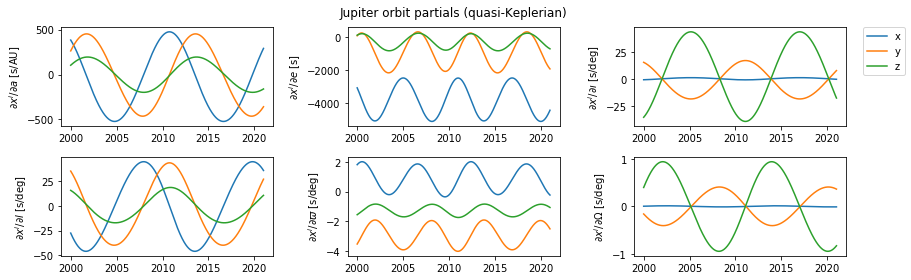

In [92]:
pp.figure(figsize=(12,4))

# tyr = 1960 + (jdates - 2436934.5)/365.25

mult = [1,1,1,1,1,-1]

for j in range(6):
    pp.subplot(2,3,j+1)

    for i in range(3):
        pp.plot(tyr, mult[j]*jpartials[j,:,i], f'C{i}')
    
    pp.ylabel([r'$\partial x^i/\partial a$ [s/AU]',
               r'$\partial x^i/\partial e$ [s]',
               r'$\partial x^i/\partial \i$ [s/deg]',
               r'$\partial x^i/\partial l$ [s/deg]',
               r'$\partial x^i/\partial \varpi$ [s/deg]',
               r'$\partial x^i/\partial \Omega$ [s/deg]'][j])
    
    if j == 1:
        pp.title('Jupiter orbit partials (quasi-Keplerian)')
        pp.gca().title.set_position([.5, 1.05])
    elif j == 2:
        pp.legend(['x','y','z'],bbox_to_anchor=(1.3, 1.05))
    
pp.tight_layout()

# pp.savefig('JupiterPartials.pdf')

Analyze the decomposition of orbel partials w.r.t. the set-III basis. The two are not equivalent.

In [93]:
for i in range(6):
    print(np.sum(decomp(jpartials[i,:,:], bsvd) * jpartials[i,:,:]) / np.sum(jpartials[i,:,:]**2))

0.051299502919307606
0.9990965532025718
0.9978716838073622
0.9999998158959355
0.9992899075215956
0.9993575086512654


In [94]:
for i in range(6):
    print(np.sum(decomp(jsvd[i,:,:], bsvd) * jsvd[i,:,:]))

0.9991464579430406
0.03512530225197337
0.9999688864535139
0.9978716881569835
0.9987134926917417
0.9993533154703638


### Saturn set-III partials

In [95]:
GMsat_AUd = GMsun_AUd / 3497.9017999999996
srmu = GMsun_AUd + GMsat_AUd

sr = xxdot(jdates, equatorial=True, tref=2440400.5, planet=saturn, x_optim=sx_optim_rates)

sset3partials = np.zeros((6,sr.shape[0],3))

for k in range(sr.shape[0]):
    sset3partials[:,k,:] = s3par6(srmu, sr[k,:])[:3,:6].T

In [96]:
sset3partials = makesetIIIpartials(jdates, tref=2440400.5,
                                    planet=saturn, x_optim=sx_optim_rates, rmu=GMsun_AUd+GMsat_AUd)

In [97]:
U, S, Vh = sla.svd(sset3partials.reshape((6, 3*sset3partials.shape[1])), full_matrices=False)
bssvd = Vh.copy().reshape((6,sset3partials.shape[1],3))

Mconvbs = U @ np.diag(S)

In [98]:
# np.save('data/setIII_partials/saturn-setIII-mjd.npy',     jdates - 2400000.5)
# np.save('data/setIII_partials/saturn-setIII-xyz.npy',     sset3partials)
# np.save('data/setIII_partials/saturn-setIII-xyz-svd.npy', bssvd)
# np.save('data/setIII_partials/saturn-setIII-Mconv.npy',   Mconvbs)

## Dynamical partials

Here we make simple dynamical partials by building a simple simulator of planetary orbits (8 planets + Sun only), and taking variations with respect to the initial conditions of each planet. We then show that these are equivalent to set III.

### Solar system simulator

In [99]:
def forces(t, vec, masses):
    """Return Newtonian-gravity accelerations for a system of bodies,
    with vec containing pos[3]/vel[3] in sequence, and masses.
    Everything in geometrical units (s), except for masses in solar masses."""
    
    # assume vector contains Sun + each planet pos[3]/vel[3] in sequence
    
    nplanets = int(len(vec)/6)
    ret = np.zeros_like(vec)
    
    for i in range(nplanets):
        # copy velocities into dx/dt
        ret[i*6:i*6+3] = vec[i*6+3:i*6+6]
        
        # make accelerations
        for j in range(nplanets):
            if i == j:
                continue
            
            d = vec[j*6:j*6+3] - vec[i*6:i*6+3] 
            r3 = np.dot(d, d)**1.5
            
            # GMSs is a solar mass in seconds, 
            ret[i*6+3:i*6+6] += GMSs * masses[j] * d / r3
    
    return ret

This Python version is pretty slow, so we translate it to Cython, which will be compiled to C.

In [100]:
%load_ext Cython

In [101]:
%%cython

import numpy as np

cimport cython
cimport numpy as np

@cython.boundscheck(False)
@cython.cdivision(True)
def cforces(double t, np.ndarray[double,ndim=1] vec, np.ndarray[double,ndim=1] masses):
    # assume vector contains Sun + each planet pos[3]/vel[3] in sequence
    
    cdef int nplanets = vec.shape[0]//6
    cdef int i, j, k
    cdef double r3, norm
    
    cdef np.ndarray[double,ndim=1] d = np.zeros(3,'d')
    cdef np.ndarray[double,ndim=1] ret = np.zeros_like(vec)
    
    cdef double GMSs = 4.925491025543576e-06
    
    if masses.shape[0] > 9:
        GMSs = masses[9]

    # cdef double dmsun = 0.0

    if masses.shape[0] > 10:
        dmsun = masses[10]
        
    for i in range(nplanets):
        ret[i*6] = vec[i*6+3]
        ret[i*6+1] = vec[i*6+4]
        ret[i*6+2] = vec[i*6+5]
        
        for j in range(nplanets):
            if i == j or masses[j] == 0.0:
                continue

            d[0] = vec[j*6] - vec[i*6] 
            d[1] = vec[j*6+1] - vec[i*6+1] 
            d[2] = vec[j*6+2] - vec[i*6+2] 
            
            r3 = (d[0]*d[0] + d[1]*d[1] + d[2]*d[2])**1.5
            
            # if j == 0:
            #     norm = GMSs * (masses[0] + t * dmsun) / r3
            # else:
            
            norm = GMSs * masses[j] / r3
            
            ret[i*6+3] += norm * d[0]
            ret[i*6+4] += norm * d[1]
            ret[i*6+5] += norm * d[2]
    
    return ret

In [102]:
def gety0(jdate, bsp=bsp436):
    """Get initial conditions from SSEs, in the form required by forces."""
    
    ret = []

    for p in range(9):
        pos, vel = getplanet(10 if p == 0 else p, jdate, bsp=bsp)
        ret.append(pos)
        ret.append(vel)
    
    return np.hstack(ret)

Our simulator will use `scipy.integrate.ode`, with a simple callback (`solout`) to collect points along the trajectory instead of the final position/velocity only. The frontend `integrate` wraps the solution in an object (appropriately, `solution`), which provides arrays of position and velocity arrays for each planet, as well as time. Additionally, the solution can be "rebased" (interpolated) to an array of times.

In [103]:
class solution:
    def __init__(self, array, masses):
        self.t = array[:,0]
        self.masses = masses
        
        np = (array.shape[1] - 1) // 6

        self.pos = [array[:, p*6+1:p*6+4] for p in range(np)]
        self.vel = [array[:, p*6+4:p*6+7] for p in range(np)]

        self._eq2ecl()
        
    def _eq2ecl(self):
        self.epos = [eq2ecl_vec(pa) for pa in self.pos]
        self.evel = [eq2ecl_vec(va) for va in self.vel]
    
    def _rebasearray(self, array, jdates):
        ret = np.zeros((len(jdates), 3), 'd')
        
        for i in range(3):
            ret[:,i] = sin.interp1d(self.t, array[:,i], kind='cubic')(jdates)
        
        return ret
    
    def rebase(self, jdates):
        self.pos = [self._rebasearray(pa, jdates) for pa in self.pos]
        self.vel = [self._rebasearray(va, jdates) for va in self.vel]
        
        self._eq2ecl()
        
        self.t = jdates
        
        return self

    
def integrate(y0, t0, t1, masses, atol=1e-10, rtol=1e-10):
    """Integrate SS between MJDs t0 and t1 starting from initial condition y0."""
    
    # times in seconds
    tfinal = (t1 - t0) * 86400
    
    # note: "dopri5" is an explicit Runge-Kutta method of order (4)5
    # due to Dormand & Prince with stepsize control and dense output
    backend = 'dopri5' # 'dop853'
    solver = si.ode(cforces).set_integrator(backend, nsteps=100000, atol=atol, rtol=rtol)

    sol = []
    def solout(t, y):
        sol.append([t, *y])

    solver.set_solout(solout)
    solver.set_initial_value(y0, 0).set_f_params(masses)
    solver.integrate(tfinal)

    ret = np.array(sol)
    
    # times back into days
    ret[:,0] = ret[:,0]/86400 + t0
    
    return solution(ret, masses)

Start at the conventional set III reference time, integrate until the end of `jdates`.

In [104]:
t0 = 2440400.5
t1 = jdates[-1]

In [105]:
s436 = integrate(gety0(t0), t0, t1, masses).rebase(jdates)

OK, they look like orbits.

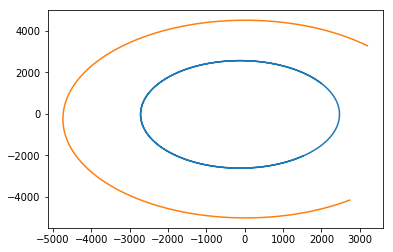

In [106]:
pp.plot(s436.epos[5][:,0], s436.epos[5][:,1])
pp.plot(s436.epos[6][:,0], s436.epos[6][:,1])

Let's compare to DE436.

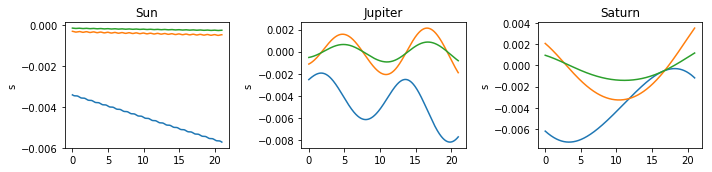

In [107]:
ps, pss = [0,5,6], ['Sun','Jupiter','Saturn']
ts = jdates - jdates[0]

pp.figure(figsize=(10,2.5))

for j,p in enumerate(ps):
    rpos, rvel = getplanet(p, jdates, bsp436)
    
    pp.subplot(1,3,j+1)
    for i in range(3):
        pp.plot(ts/365.25, s436.pos[p][:,i] - rpos[:,i])
    pp.title(f'{pss[j]}'); pp.ylabel('s')
    
pp.tight_layout()

### Correct the motion of the center of mass

In [108]:
def cmass(sol, masses):
    if isinstance(sol, np.ndarray):
        npl = len(sol) // 6
        cm = sum(masses[i] * sol[i*6:i*6+3]   for i in range(npl)) / np.sum(masses)
        cv = sum(masses[i] * sol[i*6+3:i*6+6] for i in range(npl)) / np.sum(masses)
    else:     
        cm = sum(masses[i] * pos for i, pos in enumerate(sol.pos)) / np.sum(masses)
        cv = sum(masses[i] * vel for i, vel in enumerate(sol.vel)) / np.sum(masses)
    
    return cm, cv

In [109]:
def ccorrect(self):
    cpos, cvel = cmass(self, self.masses)
    
    self.pos = [pos - cpos for pos in self.pos]
    self.vel = [vel - cvel for vel in self.vel]
    
    self._eq2ecl()
    
    return self

# monkeypatch!
solution.ccorrect = ccorrect

In [110]:
s436c = integrate(gety0(t0), t0, t1, masses).rebase(jdates).ccorrect()

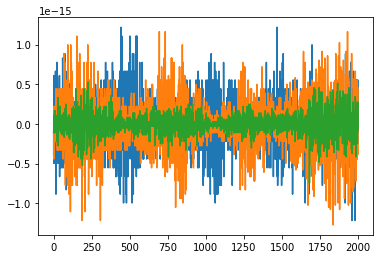

In [111]:
pp.plot(cmass(s436c, masses)[0])

In [112]:
def gety0c(t0, bsp=bsp436, dx=0):
    """Return initial conditions corrected for COM motion."""
    
    y0 = gety0(t0, bsp) + dx
    
    cp, cv = cmass(y0, masses)
    
    for p in range(len(y0) // 6):
        y0[p*6:p*6+3] -= cp
        y0[p*6+3:p*6+6] -= cv
    
    return y0

In [113]:
s436c0 = integrate(gety0c(t0), t0, t1, masses).rebase(jdates)

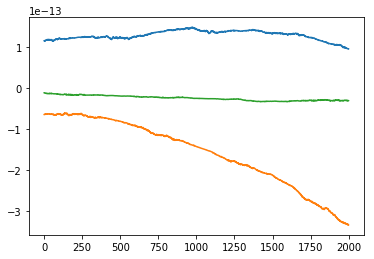

In [114]:
pp.plot(cmass(s436c0, masses)[0])

### Make partials

In [115]:
def dp(p, j):
    """Perturb planet i, component j, by d (scaled by 1e-8 for velocities.)"""
    
    ret = np.zeros(6*9, 'd')
    ret[p*6 + j] = 1e-5 if j < 3 else 1e-9
    
    return ret

In [116]:
def dynpartials(planet, jdates, bsp=bsp436, cmass=False, t0=t0, t1=t1,
                masses=masses, atol=1e-10, rtol=1e-10):
    y0 = gety0(t0)
    
    pref = integrate(gety0(t0), t0, t1, masses, atol=atol, rtol=rtol).rebase(jdates).pos[planet]
    
    ret = np.zeros((6, len(jdates), 3), 'd')
    
    for k in range(6):
        dy0 = dp(planet, k)
        y0p = gety0c(t0, bsp, dy0) if cmass else y0 + dy0
        
        ret[k,:,:] = (integrate(y0p, t0, t1, masses).rebase(jdates).pos[planet] - pref) / np.max(dy0)
        
        # these are not fast, let's show a completion bar
        print(k, end='')
    print('')
        
    return ret

In [117]:
dpartials = dynpartials(5, jdates)

012345


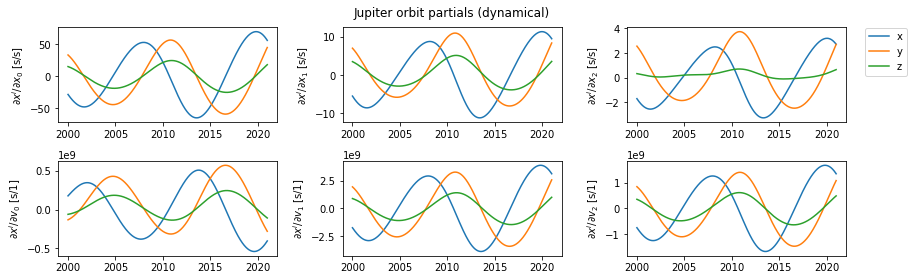

In [118]:
plotpartials(dpartials, jdates, title='Jupiter orbit partials (dynamical)')

In [119]:
dsvd, Mconvd = makesvd(dpartials)

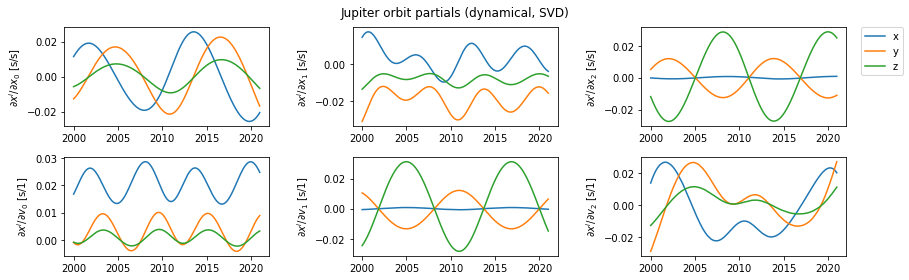

In [120]:
plotpartials(dsvd, jdates, title='Jupiter orbit partials (dynamical, SVD)')

### Compare with set III

Houston, we have a match!

In [121]:
t0 = ephem.julian_date('1969/6/28') # 2440400.5, same as covariance matrix

In [122]:
dpartials = dynpartials(5, jdates, t0=t0, t1=jdates[-1])

012345


In [123]:
set3partials = makesetIIIpartials(jdates, tref=t0)

In [124]:
dsvd, Mconvd = makesvd(dpartials)
bsvd, Mconvb = makesvd(set3partials)

for i in range(6):
    print(np.sum(decomp(dsvd[i,:,:], bsvd) * dsvd[i,:,:]) / np.sum(dsvd[i,:,:]**2))

0.9999960070300091
0.999302148174924
0.9986378501390407
0.9978965961821883
0.9978575949203187
0.9953552531381583


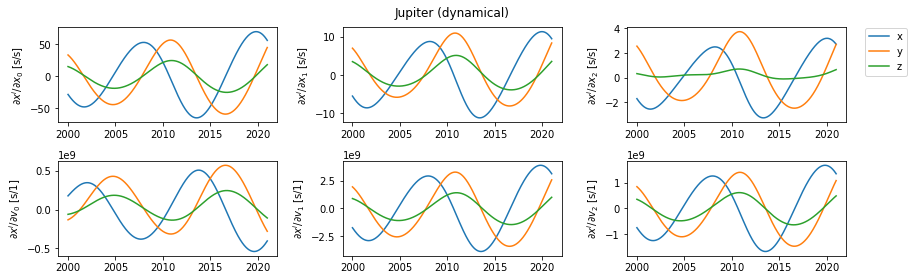

In [125]:
plotpartials(dpartials, jdates, "Jupiter (dynamical)")

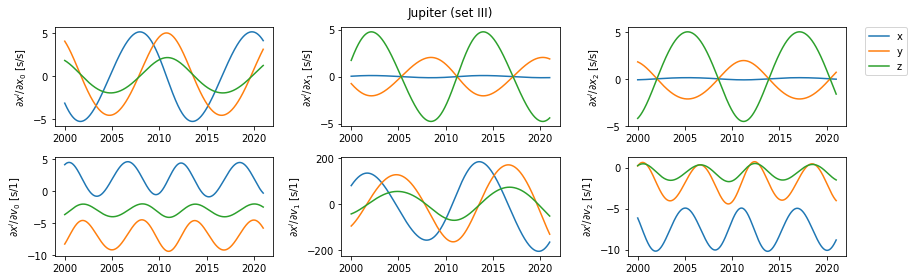

In [126]:
plotpartials(set3partials, jdates, "Jupiter (set III)")

## Compare Roemer delays after orbital-element corrections

Again, our pulsar directions.

In [127]:
random.seed(42)
ks = [randk() for k in range(100)]

We'll look at the approximate timespan of the NANOGrav 11-yr dataset.

In [128]:
jdates10 = np.linspace(ephem.julian_date('2005/1/1'),ephem.julian_date('2015/12/31'),2000)

jpartials10 = planetpartials(jup, jdates10, jx_optim, bug=False)
jspartials10 = np.vstack((planetpartials(jup, jdates10, jx_optim, bug=False),
                          planetpartials(sat, jdates10, sx_optim, bug=False)))

Plot Roemer-delay differences between SSEs, as induced by planet `p`, for pulsars in directions `ks`. Do the standard timing-model (per-pulsar) subtractions (`project=True`) and additional project out SSE `partials`. This can be done per-pulsar, or in a more realistic global fashion. 

In [129]:
def plotroemers(p, jdates, bsp1, bsp2, ks, project=True, partials=None, globalfit=False, yrange=125):
    d0 = 1960 + (jdates[0] - 2436934.5)/365.25
    
    if globalfit:
        rs = globalroemers(0, jdates, bsp1, bsp2, ks, project=project, partials=partials)
    else:
        rs = getroemers(0, jdates, bsp1, bsp2, ks, project=project, partials=partials)
    
    for r in rs[:-4]:
        pp.plot(d0 + (jdates - jdates[0])/365.25, r, color='C3', alpha=0.3)
        
    for i,r in enumerate(rs[-4:]):
        pp.plot(d0 + (jdates - jdates[0])/365.25, r, color='k', linestyle=['-',':','--','-.'][i])
    
    pp.ylabel('ns')
    pp.axis(ymin=-yrange, ymax=yrange)

In [130]:
def getroemers(p, jdates, bsp1, bsp2, ks, project=True, partials=None):
    pos1, _ = getplanet(p, jdates, bsp1)
    pos2, _ = getplanet(p, jdates, bsp2)

    roemer = np.zeros((len(ks),len(jdates)),'d')
    
    for i,k in enumerate(ks):
        roemer[i,:] = np.dot(pos1 - pos2, k)

    t = (jdates - jdates[0])/365.25

    # project out a constant, linear, quadratic, and yearly sinusoids
    
    ys = []
    ys.append(xnorm(np.ones(len(jdates), 'd')))
    ys.append(xnorm(np.linspace(0.0, 1.0, len(jdates))))
    ys.append(xnorm(ys[-1]*ys[-1]))
    ys.append(xnorm(np.sin(2*math.pi*t)))
    ys.append(xnorm(np.cos(2*math.pi*t)))
    
    # linearly modulated sinusoids
    # ys.append(xnorm(ys[1]*np.sin(2*math.pi*t)))
    # ys.append(xnorm(ys[1]*np.cos(2*math.pi*t)))
                
    if project:
        for i,k in enumerate(ks):
            kys = ys.copy()
            
            if partials is not None:
                for j in range(partials.shape[0]):
                    kys.append(xnorm(np.dot(partials[j,:,:], k)))
            
            for ky in orthonorm(kys):
                roemer[i,:] -= np.dot(roemer[i,:], ky) * ky
        
    return roemer / 1e-9

In [131]:
def globalroemers(p, jdates, bsp1, bsp2, ks, project=True, partials=None):
    pos1, _ = getplanet(p, jdates, bsp1)
    pos2, _ = getplanet(p, jdates, bsp2)

    roemer = np.zeros((len(ks),len(jdates)),'d')
    
    for i,k in enumerate(ks):
        roemer[i,:] = np.dot(pos1 - pos2, k)
        
    t = (jdates - jdates[0])/365.25

    # project out a constant, linear, quadratic, and yearly sinusoids
    
    def multiply(a):
        return np.concatenate([a for k in ks])
            
    ys = []
    ys.append(xnorm(multiply(np.ones(len(jdates), 'd'))))
    ys.append(xnorm(multiply(np.linspace(0.0, 1.0, len(jdates)))))
    ys.append(xnorm(ys[-1]*ys[-1]))
    ys.append(xnorm(multiply(np.sin(2*math.pi*t))))
    ys.append(xnorm(multiply(np.cos(2*math.pi*t))))
    
    if partials is not None:
        for j in range(partials.shape[0]):
            ys.append(xnorm(np.concatenate([np.dot(partials[j,:,:], k) for k in ks])))
            
    if project:
        oys = orthonorm(ys)

        for i,k in enumerate(ks):            
            for y in oys[:5]:
                roemer[i,:] -= np.dot(roemer[i,:], xnorm(y[:len(jdates)])) * xnorm(y[:len(jdates)])
        
        if partials is not None:
            roemer = roemer.flatten() 
            # print(np.sum(roemer**2))

            for y in oys[5:]:
                roemer[:] -= np.dot(roemer, y) * y

            # print(np.sum(roemer**2))
            roemer = roemer.reshape((len(ks),len(jdates)))

        for i,k in enumerate(ks):            
            for y in oys[:5]:
                roemer[i,:] -= np.dot(roemer[i,:], xnorm(y[:len(jdates)])) * xnorm(y[:len(jdates)])
            
    return roemer / 1e-9

Applied to individual pulsars, the Jupiter partials can reduce Roemer to less than 10 ns.

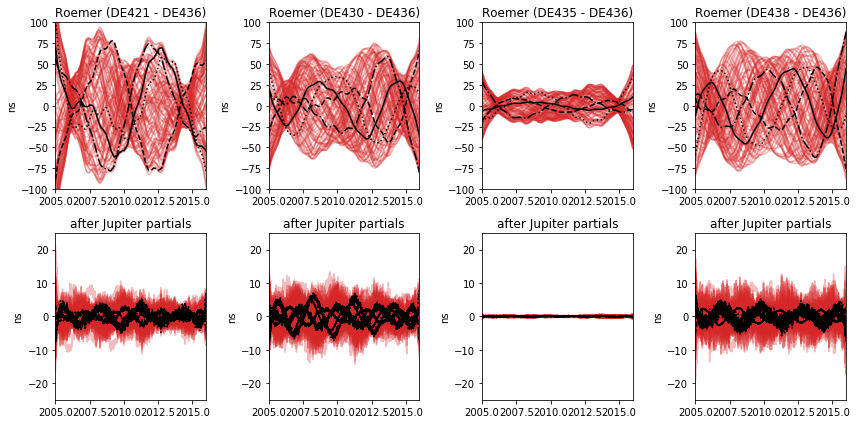

In [132]:
pp.figure(figsize=(12,6))

for j, (bsp, bspname) in enumerate(zip([bsp421,bsp430,bsp435,bsp438],['DE421','DE430','DE435','DE438'])):
    pp.subplot(2,4,j+1); plotroemers(5, jdates10, bsp, bsp436, ks, yrange=100)
    pp.title(f'Roemer ({bspname} - DE436)'); pp.axis(xmin=2005,xmax=2016)

for j, (bsp, bspname) in enumerate(zip([bsp421,bsp430,bsp435,bsp438],['DE421','DE430','DE435','DE438'])):
    pp.subplot(2,4,j+5); plotroemers(5, jdates10, bsp, bsp436, ks, partials=jpartials10[:,:,:], yrange=25)
    pp.title(f'after Jupiter partials'); pp.axis(xmin=2005,xmax=2016)

pp.tight_layout()

Applied to all pulsars simultaneously, the effect is much less dramatic. But we shouldn't think of BayesEphem as absorbing the SSE differences period, but rather as allowing a range of SSE variation that is comparable to the differences between SSEs.

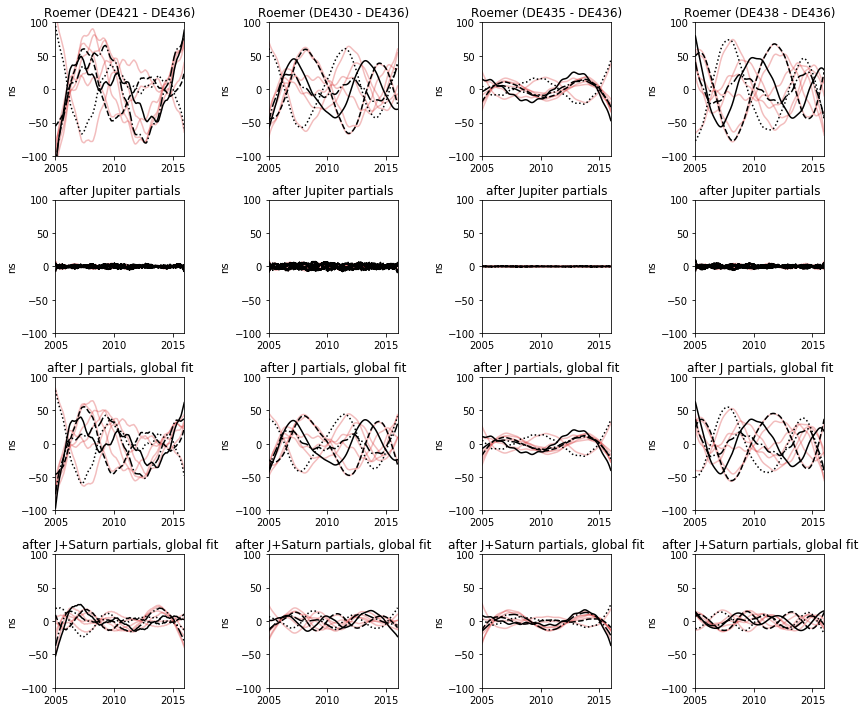

In [133]:
pp.figure(figsize=(12,10))

for j, (bsp, bspname) in enumerate(zip([bsp421,bsp430,bsp435,bsp438],['DE421','DE430','DE435','DE438'])):
    pp.subplot(4,4,j+1); plotroemers(5, jdates10, bsp, bsp436, ks[:10], project=True, yrange=100)
    pp.title(f'Roemer ({bspname} - DE436)'); pp.axis(xmin=2005,xmax=2016)

for j, (bsp, bspname) in enumerate(zip([bsp421,bsp430,bsp435,bsp438],['DE421','DE430','DE435','DE438'])):
    pp.subplot(4,4,j+5); plotroemers(5, jdates10, bsp, bsp436, ks[:10], project=True, partials=jpartials10, yrange=100)
    pp.title(f'after Jupiter partials'); pp.axis(xmin=2005,xmax=2016)

for j, (bsp, bspname) in enumerate(zip([bsp421,bsp430,bsp435,bsp438],['DE421','DE430','DE435','DE438'])):
    pp.subplot(4,4,j+9); plotroemers(5, jdates10, bsp, bsp436, ks[:10], globalfit=True, partials=jpartials10, yrange=100)
    pp.title(f'after J partials, global fit'); pp.axis(xmin=2005,xmax=2016)
    
for j, (bsp, bspname) in enumerate(zip([bsp421,bsp430,bsp435,bsp438],['DE421','DE430','DE435','DE438'])):
    pp.subplot(4,4,j+13); plotroemers(5, jdates10, bsp, bsp436, ks[:10], globalfit=True, partials=jspartials10, yrange=100)
    pp.title(f'after J+Saturn partials, global fit'); pp.axis(xmin=2005,xmax=2016)

pp.tight_layout()

## Plotting GW and Jupiter-element posteriors (paper figure 1, 5)

These are just annoying conditionals to load the right posterior NumPy file for a given SSE and model. Note that as we write 12.5-yr runs are provisional and are not included with the published version of this notebook. 

In [134]:
@functools.lru_cache(maxsize=128)
def getpost(eph='DE421', model='2a', partials='setIII', dataset='11yr', bayesephem=True, freqs=5, dcov=None):
    if bayesephem is False:
        partials = ''
    else:
        partials = partials + '_'
    
    if dataset == '11yr':
        datadir = 'chains/11yr_Shortened_BayesEphem_Chains'
        if dcov:
            template = f'11yr_{eph}_BE_{bayesephem}_Dcov{dcov}_{partials}{model}_cRN{freqs}freqs_gammaFixed_4.33.npy'
        else:
            if eph != 'DE438':
                freqs = 30
                
            template = f'11yr_{eph}_BE_{bayesephem}_{partials}{model}_cRN{freqs}freqs_gammaFixed_4.33.npy'
    else:    
        datadir = 'chains/12p5yr_Shortened_BayesEphem_Chains'
        if dcov:
            template = f'12p5yr_{eph}_BE_{bayesephem}_Dcov{dcov}_{partials}{model}_cRN{freqs}freqs_gammaFixed_4.33.npy'
        else:
            template = f'12p5yr_{eph}_BE_{bayesephem}_{partials}{model}_cRN{freqs}freqs_gammaFixed_4.33.npy'
    
    # print(template)
    
    return np.load(os.path.join(datadir,template))

In [135]:
@functools.lru_cache(maxsize=128)
def getposts(eph='DE421', model='2a', partials='setIII', dataset='11yr', bayesephem=True, limit=False):
    if bayesephem is False:
        partials = ''
    else:
        partials = partials + '_'
    
    if dataset == '11yr':
        datadir = 'chains/Shortened_11yr_BayesEphem_Chains_From_Steve'
        template = f'chains_nano11_ephcompare_model_{model}_{eph}_bayesephem_{bayesephem}_{partials}limit_{limit}_gammaFixed_4.3333_.npy'
        
    return np.load(os.path.join(datadir,template))

### GW amplitude posteriors

#### Load downsampled $A_\mathrm{GW}$ chains from MCMC runs

The `gw_setIII` runs were compiled by Joe Simon in Q3 and Q4 2019. They cover all SSEs and BayesEphem set-III and quasi-Keplerian (+`o`) partials.

In [136]:
gw_setIII = {}

for eph in ['DE421','DE430','DE435','DE436','DE438']:
    gw_setIII[eph] = getpost(eph)[:,5]
    
    if eph != 'DE438':
        gw_setIII[eph + 'o'] = getpost(eph, partials='orbel-v2')[:,5]

# model 3a (only a couple of runs)
gw_setIII['DE436-3'] = getpost('DE436',model='3a')[:,5]
gw_setIII['DE436-3o'] = getpost('DE436',model='3a',partials='orbel-v2')[:,5]

The `gw_steve` runs were compiled by Stephen Taylor in Q3 and Q4 2019. They cover all SSEs, BayesEphem set III (no extra letter), quasi-Keplerian (`o` == `orbel-v2`), older/buggy quasi-Keplerian (`o1` == `orbel`), spatially correlated model 3A (`3`), and no BayesEphem (`f`). The GW amplitude is given a log-uniform posterior and a linearly-uniform posterior (`L`) as appropriate for upper limits.

In [137]:
gw_steve = {}

for eph in ['DE421','DE430','DE435','DE436','DE438']:
    # detection runs
    
    # model 2A no BayesEphem
    gw_steve[eph + 'f'] = getposts(eph,bayesephem=False)[:,0]

    # model 2A, BayesEphem set III
    gw_steve[eph]        = getposts(eph)[:,5]
    # model 2A, BayesEphem quasi-Keplerian
    gw_steve[eph + 'o']  = getposts(eph,partials='orbel-v2')[:,5]
    # model 2A, BayesEphem older quasi-Keplerian partials
    gw_steve[eph + 'o1'] = getposts(eph,partials='orbel')[:,5]   

    # same for model 3A
    gw_steve[eph + '3'] = getposts(eph,model='3a')[:,5]
    gw_steve[eph + '3o'] = getposts(eph,partials='orbel-v2',model='3a')[:,5]
    gw_steve[eph + '3o1'] = getposts(eph,partials='orbel',model='3a')[:,5]
    
    # same for upper limit runs
    
    gw_steve['L' + eph + 'f']  = getposts(eph,limit=True,bayesephem=False)[:,0]

    gw_steve['L' + eph]        = getposts(eph,limit=True)[:,5]
    gw_steve['L' + eph + 'o']  = getposts(eph,limit=True,partials='orbel-v2')[:,5]
    gw_steve['L' + eph + 'o1'] = getposts(eph,limit=True,partials='orbel')[:,5]
    
    gw_steve['L' + eph + '3']   = getposts(eph,limit=True,model='3a')[:,5]
    gw_steve['L' + eph + '3o']  = getposts(eph,limit=True,partials='orbel-v2',model='3a')[:,5]
    gw_steve['L' + eph + '3o1'] = getposts(eph,limit=True,partials='orbel',model='3a')[:,5]

#### Effect on $A_\mathrm{GW}$ upper limits

In [138]:
if not hasattr(np, 'quantile'):
    np.quantile = lambda a, q: np.percentile(a,100*q)

Compile upper limits, including some numbers from the 11-yr paper.

In [139]:
ephs = ['DE421','DE430','DE435','DE436','DE438']

def getlimit(model):
    return ['{:.2e}'.format(10**np.quantile(gw_steve['L' + eph + model],0.95)) for eph in ephs]

# return bootstrapped limit, with fractional bootstrap variance
# not used below, but gives errors ~ 0.01e-15
def getlimitb(model, eph):
    bs = aps.bootstrap(gw_steve['L' + eph + model], 1000, 
                       bootfunc=lambda d: 10**np.quantile(d, 0.95))
    
    return np.mean(bs), math.sqrt(np.var(bs))/np.mean(bs)

limits = {
    'eph': ephs,
    'fixed': getlimit('f'),
    'paper': ['1.51e-15','1.76e-15','1.57e-15','1.61e-15','N/A'],
    'setIII': getlimit(''),
    'orb-v2': getlimit('o'),
    'orb-v1': getlimit('o1'),
    'p. BE': ['1.34e-15','--','--','--','N/A'],
    'setIII 3a': getlimit('3'),
    'orb-v2 3a': getlimit('3o'),
    'orb-v1 3a': getlimit('3o1'),
    'p. BE 3a': ['1.45e-15','--','--','--','N/A'],
}

print(tabulate.tabulate(limits,
                        headers=list(limits.keys())))

eph       fixed  paper       setIII    orb-v2    orb-v1  p. BE       setIII 3a    orb-v2 3a    orb-v1 3a  p. BE 3a
-----  --------  --------  --------  --------  --------  --------  -----------  -----------  -----------  ----------
DE421  1.54e-15  1.51e-15  1.32e-15  1.35e-15  1.31e-15  1.34e-15     1.45e-15     1.53e-15     1.33e-15  1.45e-15
DE430  1.76e-15  1.76e-15  1.31e-15  1.33e-15  1.33e-15  --           1.42e-15     1.5e-15      1.36e-15  --
DE435  1.59e-15  1.57e-15  1.38e-15  1.4e-15   1.34e-15  --           1.48e-15     1.55e-15     1.45e-15  --
DE436  1.64e-15  1.61e-15  1.38e-15  1.41e-15  1.31e-15  --           1.48e-15     1.53e-15     1.39e-15  --
DE438  1.94e-15  N/A       1.45e-15  1.44e-15  1.37e-15  N/A          1.5e-15      1.51e-15     1.54e-15  N/A


Upper limits may also be derived by reweighting the detection runs. The results are compatible, but wobbly.

In [140]:
def intlimit(model, dataset='11yr'):
    ret = []
    for eph in ephs:
        try:
            if dataset == '11yr':
                logAgw = gw_setIII[eph + model] if '43' in model else gw_steve[eph + model]
            else:
                logAgw = gw_setIII_12[eph + model]
        except KeyError:
            ret.append('N/A')
            continue
        
        # ret.append(logAgw); continue
        
        logAgw = logAgw[logAgw > -16.5]
        
        weights = 10**logAgw

        cdf = np.cumsum(weights) / np.cumsum(weights)[-1]
        lim = np.interp(0.95, cdf, logAgw)
        
        ret.append('{:.2e}'.format(10**lim))
        
    return ret

In [141]:
intlimits = {
    'eph': ephs,
    'fixed': intlimit('f'),
    'paper': ['1.51e-15','1.76e-15','1.57e-15','1.61e-15','N/A'],
    'setIII': intlimit(''),
    'orb-v2': intlimit('o'),
    'orb-v1': intlimit('o1'),
    'p. BE': ['1.34e-15','--','--','--','N/A'],
    'setIII 3a': intlimit('3'),
    'orb-v2 3a': intlimit('3o'),
    'orb-v1 3a': intlimit('3o1'),
    'p. BE 3a': ['1.45e-15','--','--','--','N/A'],
}

print(tabulate.tabulate(intlimits,
                        headers=list(intlimits.keys())))

eph       fixed  paper       setIII    orb-v2    orb-v1  p. BE       setIII 3a    orb-v2 3a    orb-v1 3a  p. BE 3a
-----  --------  --------  --------  --------  --------  --------  -----------  -----------  -----------  ----------
DE421  1.62e-15  1.51e-15  5.71e-16  1.71e-15  8.67e-16  1.34e-15     7.41e-16     4.47e-16     3.29e-16  1.45e-15
DE430  1.05e-15  1.76e-15  1.37e-15  8.99e-16  6.27e-16  --           5.86e-16     6.31e-16     3.25e-16  --
DE435  1.39e-15  1.57e-15  4e-16     7.09e-16  1.58e-15  --           1.98e-15     1.59e-15     8.95e-16  --
DE436  1.17e-15  1.61e-15  7.36e-16  9.07e-16  3.9e-16   --           5.83e-16     2.67e-15     1.92e-16  --
DE438  1.12e-15  N/A       5.79e-16  1.56e-15  1.18e-15  N/A          1.85e-15     8.88e-16     6.11e-16  N/A


#### Effect on detection Bayes ratios

Savage--Dickey BFs: evidence(zero Agw)/evidence(variable Agw) = posterior(Agw = 0)/prior(Agw = 0). See https://www.ejwagenmakers.com/2010/WagenmakersEtAlCogPsy2010.pdf.

In [142]:
rng = [-18,-14] # from runs

def getBF(model, dataset='11yr', sdbins=15):
    ret = []
    
    for eph in ephs:
        try:
            if dataset == '11yr':
                data = gw_setIII[eph + model] if '43' in model else gw_steve[eph + model]
            else:
                data = gw_setIII_12[eph + model]
        except KeyError:
            ret.append('N/A')
            continue
            
        samples = np.histogram(data, bins=50, density=True, range=[-17,-14])[0][:sdbins]
        bf = np.median(aps.bootstrap(samples, bootnum=1000, bootfunc=np.mean)) * (rng[1] - rng[0])
        ret.append('{:.2f}'.format(1/bf))
        
    return ret

Check S-D ratio convergence

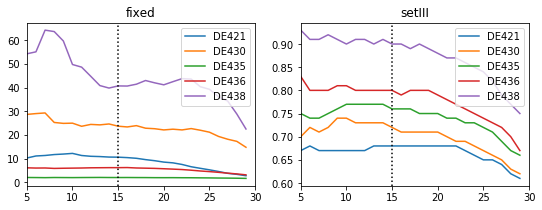

In [143]:
pp.figure(figsize=(9,3))

pp.subplot(1,2,1)

sdcheck = np.array([list(map(float,getBF('f',sdbins=s))) for s in range(5,30)])
for i in range(5):
    pp.plot(range(5,30),sdcheck[:,i],label=ephs[i])
pp.legend(); pp.axis(xmin=5,xmax=30); pp.title('fixed')
pp.axvline(15,c='k',ls=':')

pp.subplot(1,2,2)

sdcheck = np.array([list(map(float,getBF('',sdbins=s))) for s in range(5,30)])
for i in range(5):
    pp.plot(range(5,30),sdcheck[:,i],label=ephs[i])
pp.legend(); pp.axis(xmin=5,xmax=30); pp.title('setIII')
pp.axvline(15,color='k',ls=':')

Get more data: constrained runs with JPL priors

In [144]:
gw_setIII['DE436+434'] = getpost('DE436',dataset='11yr',partials='setIII',dcov='434')[:,5]
gw_setIII['DE438+434'] = getpost('DE438',dataset='11yr',partials='setIII',dcov='434')[:,5]
gw_setIII['DE438+438'] = getpost('DE438',dataset='11yr',partials='setIII',dcov='438')[:,5]

Tabulate the Bayes factors

In [145]:
bfs = {
    'eph': ephs,
    'fixed': getBF('f'),
    'p.': ['8.28','18.9','1.82','4.4','N/A'],
    'setIII': getBF(''),
    'orb-v2': getBF('o'),
    'orb-v1': getBF('o1'),
    'p.BE': ['0.88','--','--','--','N/A'],
    'setIII 3a': getBF('3'),
    'orb-v2 3a': getBF('3o'),
    'orb-v1 3a': getBF('3o1'),
    'p.BE3a': ['1.00','--','--','--','N/A'],
    'dcov438': getBF('+438')
}

print(tabulate.tabulate(bfs,
                        headers=list(bfs.keys())))

eph      fixed  p.      setIII    orb-v2    orb-v1  p.BE      setIII 3a    orb-v2 3a    orb-v1 3a  p.BE3a    dcov438
-----  -------  ----  --------  --------  --------  ------  -----------  -----------  -----------  --------  ---------
DE421    10.56  8.28      0.68      0.68      0.6   0.88           0.77         0.71         0.62  1.00      N/A
DE430    23.69  18.9      0.72      0.71      0.61  --             0.73         0.79         0.69  --        N/A
DE435     1.98  1.82      0.76      0.72      0.65  --             0.76         0.87         0.68  --        N/A
DE436     6.15  4.4       0.8       0.72      0.69  --             0.8          0.87         0.62  --        N/A
DE438    40.73  N/A       0.9       0.86      0.67  N/A            0.9          0.86         0.79  N/A       15.01


#### Effect on $A_\mathrm{GW}$ posteriors

Starting with every SSE, applying BayesEphem removes GW power, and turns more pointed posteriors to flatter ones. Model-2A and -3A posteriors with BayesEphem are compatible. Here "fix" denotes runs without BayesEphem.

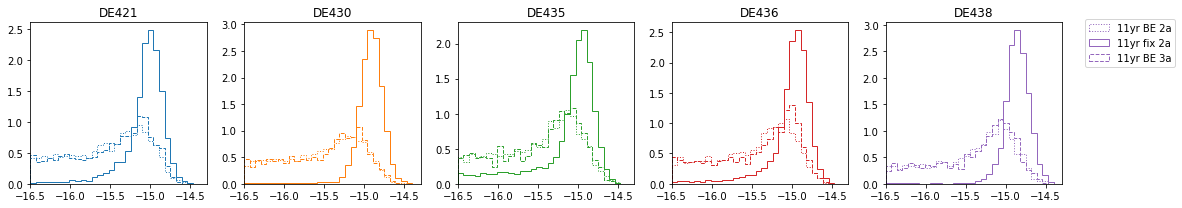

In [146]:
pp.figure(figsize=(15,3))

for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):
    pp.subplot(1,5,i+1)

    pp.hist(gw_steve[eph][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', ls=':', label='11yr BE 2a')
    pp.hist(gw_steve[eph + 'f'][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', label='11yr fix 2a') 
    pp.hist(gw_steve[eph + '3'][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', ls='--', label='11yr BE 3a') 
    
    pp.axis(xmin=-16.5)
    pp.title(eph)

pp.legend(bbox_to_anchor=(1.1, 1.05))
    
pp.tight_layout()

Same plots, but comparing different SSEs for no BayesEphem ("fixed"), BayesEphem model-2A, BayesEphem model-3A. The fixed runs do not agree, the BayesEphem runs are "bridged".

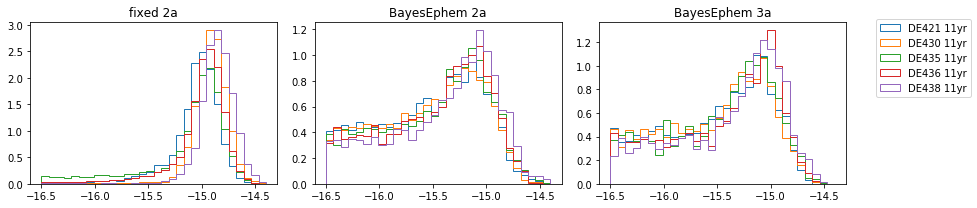

In [147]:
pp.figure(figsize=(12,3))

pp.subplot(1,3,1)
for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):    
    pp.hist(gw_steve[eph + 'f'][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', label=eph + ' 11yr')
pp.title('fixed 2a')
    
pp.subplot(1,3,2)
for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):    
    pp.hist(gw_steve[eph][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', label=eph + ' 11yr')
pp.title('BayesEphem 2a')

pp.subplot(1,3,3)
for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):    
    pp.hist(gw_steve[eph + '3'][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', label=eph + ' 11yr')
pp.title('BayesEphem 3a')

pp.legend(bbox_to_anchor=(1.1, 1.05))
    
pp.tight_layout()

Same, in vertical log scale.

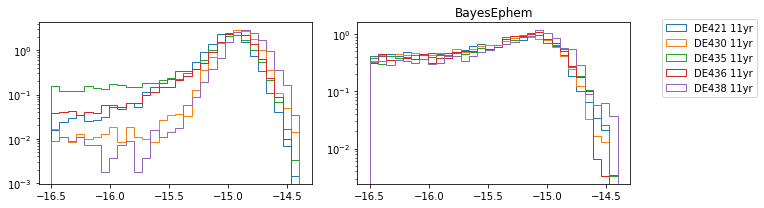

In [148]:
pp.figure(figsize=(9,3))

pp.subplot(1,2,1)
for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):    
    pp.hist(gw_steve[eph + 'f'][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', label=eph + ' 11yr')
    pp.yscale('log', nonposy='clip')
    
pp.subplot(1,2,2)
for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):    
    pp.hist(gw_steve[eph][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', label=eph + ' 11yr')
    pp.yscale('log', nonposy='clip')
pp.title('BayesEphem')
    
pp.legend(bbox_to_anchor=(1.1, 1.05))
    
pp.tight_layout()

Figure 1 for paper.

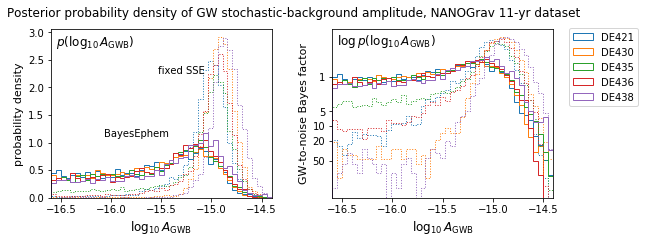

In [149]:
agwrange = [-16.6,-14.4]
agwbins = 45

pp.figure(figsize=(9,3.1))

pp.subplot(1,2,1)

for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):    
    pp.hist(gw_steve[eph][:], histtype='step', density=True, bins=agwbins, range=agwrange,
            color=f'C{i}', label=eph)

    pp.hist(gw_steve[eph + 'f'][:], histtype='step', density=True, bins=agwbins, range=agwrange,
            color=f'C{i}', ls=':', label=eph)    

pp.axis(xmin=agwrange[0],xmax=agwrange[1])
pp.xticks([-16.5,-16,-15.5,-15,-14.5])
pp.xlabel('$\log_{10}\, A_\mathrm{GWB}$',fontsize=12)
pp.ylabel('probability density',fontsize=11)

pp.text(-16.55,2.75,'$p(\log_{10}\, A_\mathrm{GWB})$',fontsize=12)

pp.text(-15.3,2.25,'fixed SSE',ha='center')
pp.text(-15.75,1.1,'BayesEphem',ha='center')

pp.subplot(1,2,2)

for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):    
    pp.hist(gw_steve[eph][:], histtype='step', density=True, bins=agwbins, range=agwrange,
            color=f'C{i}', label=eph)
    pp.yscale('log', nonposy='clip')
    
    pp.hist(gw_steve[eph + 'f'][:], histtype='step', density=True, bins=agwbins, range=agwrange,
            color=f'C{i}', ls=':')
#    pp.yscale('log', nonposy='clip')

pp.axis(xmin=agwrange[0],xmax=agwrange[1])
pp.xticks([-16.5,-16,-15.5,-15,-14.5])
pp.xlabel('$\log_{10}\, A_\mathrm{GWB}$',fontsize=12)

norm = 4/(agwrange[1] - agwrange[0])

pp.minorticks_off()
pp.yticks([norm/(4*v) for v in [1,5,10,20,50]],[1,5,10,20,50])
pp.ylabel('GW-to-noise Bayes factor',fontsize=11)

pp.text(-16.55,2,'$\log \, p(\log_{10}\, A_\mathrm{GWB})$',fontsize=12)

pp.legend(bbox_to_anchor=(1.05, 1.035))

pp.suptitle('Posterior probability density of GW stochastic-background amplitude, NANOGrav 11-yr dataset')

pp.subplots_adjust(wspace=0.275)
# pp.tight_layout()

# pp.savefig('GWposterior.pdf',bbox_inches = 'tight')

Compare different partials (orbel, orbel-v2, setIII). Some difference in DE421, DE438 only with the buggy `orbel`.

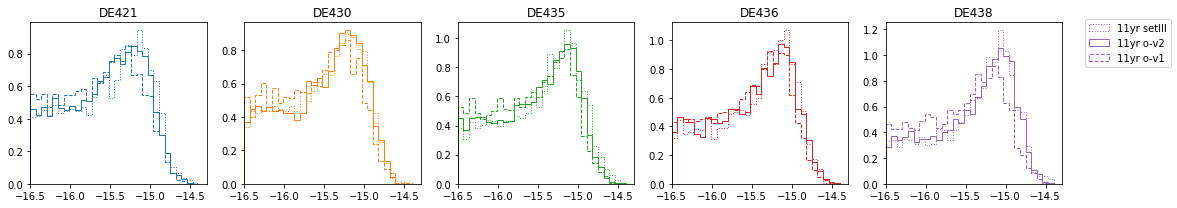

In [150]:
pp.figure(figsize=(15,3))

for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):
    pp.subplot(1,5,i+1)

    pp.hist(gw_steve[eph][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', ls=':', label='11yr setIII')
    pp.hist(gw_steve[eph + 'o'][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', label='11yr o-v2') 
    pp.hist(gw_steve[eph + 'o1'][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', ls='--', label='11yr o-v1') 
    
    pp.axis(xmin=-16.5)
    pp.title(eph)

pp.legend(bbox_to_anchor=(1.1, 1.05))
    
pp.tight_layout()

Compare Steve's runs with Joe's runs on 11yr `SetIII`. Good agreement that gives an idea of sampling error.

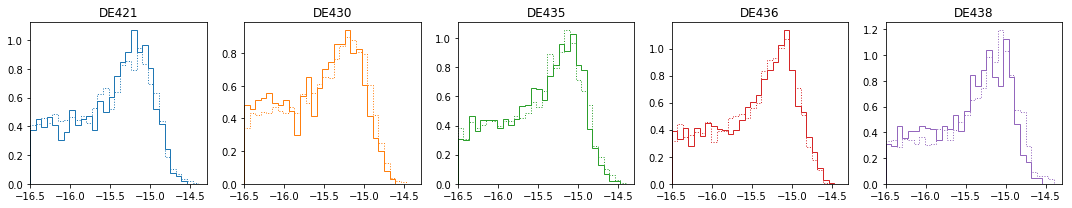

In [151]:
pp.figure(figsize=(15,3))

for i,eph in enumerate(['DE421','DE430','DE435','DE436','DE438']):
    pp.subplot(1,5,i+1)

    pp.hist(gw_steve[eph][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', ls=':', label=eph + '11yr')
    pp.hist(gw_setIII[eph][:], histtype='step', density=True, bins=30, range=[-16.5,-14.4],
            color=f'C{i}', label=eph + '11yr') 
    
    pp.axis(xmin=-16.5)
    pp.title(eph)
    
pp.tight_layout()

### Orbit corrections

#### Load downsampled chains from MCMC runs

To convert from SVD set III coefficients to natural ones, we use the `Mconv` matrix (defined above), which is such that $c_\mathrm{SVD} = c_\mathrm{phys} \cdot M$, hence $c_\mathrm{phys} =  c_\mathrm{SVD} \cdot M^{-1}$.

In [152]:
Mconvb = np.load('../data/setIII_partials/jupiter-setIII-Mconv.npy')

In [153]:
de_setIII = {}

de_setIII['DE421'] = getposts('DE421')[:,6:] @ np.linalg.inv(Mconvb)
de_setIII['DE430'] = getposts('DE430')[:,6:] @ np.linalg.inv(Mconvb)
de_setIII['DE435'] = getposts('DE435')[:,6:] @ np.linalg.inv(Mconvb)
de_setIII['DE436'] = getposts('DE436')[:,6:] @ np.linalg.inv(Mconvb)
de_setIII['DE438'] = getposts('DE438')[:,6:] @ np.linalg.inv(Mconvb)

dm_setIII = {}

dm_setIII['DE421'] = getposts('DE421')[:,:5]
dm_setIII['DE430'] = getposts('DE430')[:,:5]
dm_setIII['DE435'] = getposts('DE435')[:,:5]
dm_setIII['DE436'] = getposts('DE436')[:,:5]
dm_setIII['DE438'] = getposts('DE438')[:,:5]

#### JPL correlation matrices

DE434 uncertainty estimate, given as covariance matrix for set III parameters. The `APCSCALE` multiplies the covariance-matrix elements.

In [154]:
APCNAME = ['DMW5','DP5','DQ5','EDW5','DA5','DE5']

APCSCALE1 = 6

APCOV1 = np.zeros((6,6),'d')

APCOV1[0,0:1] = [ 1.527621387618E-15]
APCOV1[1,0:2] = [ 1.058311905401E-16,  9.908144821626E-16]
APCOV1[2,0:3] = [ 1.325206907371E-16,  7.800126497261E-16,  1.484869687029E-15]
APCOV1[3,0:4] = [-5.554347232525E-17, -1.805266759308E-18, -3.219245713312E-18,  3.943475941450E-18]
APCOV1[4,0:5] = [ 5.829025102220E-17,  2.411095852154E-18,  3.120922611115E-18, -1.149409771728E-18,  2.730094171917E-18]
APCOV1[5,0:6] = [-1.517335230324E-16, -1.514060345995E-17, -1.982573561138E-17,  7.340771399985E-18, -4.843232999649E-18,  1.686941960642E-17]

for i in range(6):
    for j in range(i+1,6):
        APCOV1[i,j] = APCOV1[j,i]

DE438 uncertainty estimate, given as covariance matrix for set III parameters.

In [155]:
APCSCALE2 = 1

APCOV2 = np.zeros((6,6),'d')

APCOV2[0,:] = [ 2.210745064289020E-16,   -9.302293375674120E-18,   -3.110752139848730E-18,
                8.915141678985930E-18,    6.585088000253370E-18,   -9.695130040039770E-18]
APCOV2[1,:] = [-9.302293375674120E-18,    1.689668129497120E-16,    1.799196388355480E-18,
               -1.543865383055090E-19,   -2.650163745861110E-19,    3.734006898576160E-19]
APCOV2[2,:] = [-3.110752139848730E-18,    1.799196388355480E-18,    6.295019839494140E-18,
               -1.317807768850900E-19,   -1.160517503280710E-19,    1.524195753224690E-19]
APCOV2[3,:] = [ 8.915141678985930E-18,   -1.543865383055090E-19,   -1.317807768850900E-19,
                7.051446252940240E-19,    2.860665706721590E-19,   -4.200761108747160E-19]
APCOV2[4,:] = [ 6.585088000253370E-18,   -2.650163745861110E-19,   -1.160517503280710E-19,
                2.860665706721590E-19,    1.995406804828660E-19,   -2.919312012982260E-19]
APCOV2[5,:] = [-9.695130040039770E-18,    3.734006898576160E-19,    1.524195753224690E-19,
               -4.200761108747160E-19,   -2.919312012982260E-19,    4.831165400437490E-19]

In [156]:
apcind = {'DMW': 0, 'DP': 1, 'DQ': 2, 'EDW': 3, 'DA': 4, 'DE': 5}

Let's see them together.

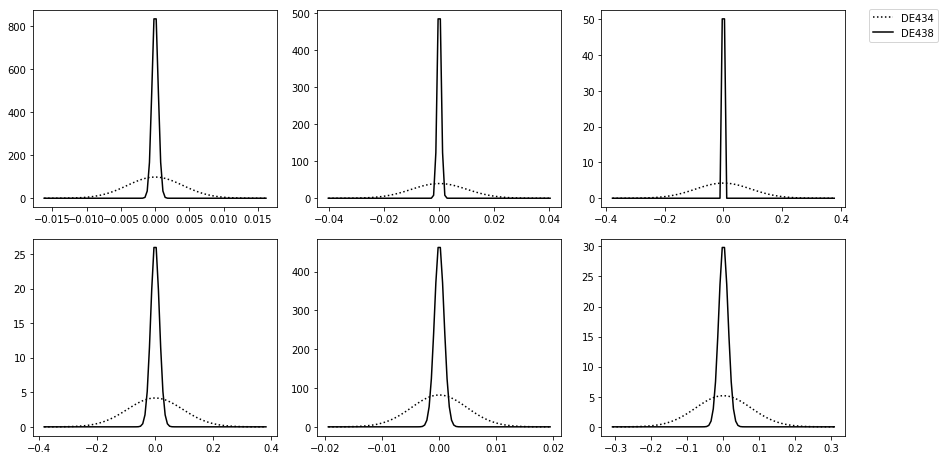

In [157]:
pp.figure(figsize=(12,6.5))

for i,var in enumerate(['DA', 'DE', 'DQ', 'DMW', 'EDW', 'DP']):
    pp.subplot(2,3,i+1)

    sigma = math.sqrt(np.diag(APCSCALE1 * APCOV1)[apcind[var]]) / 1e-6
    
    x = np.linspace(-4*sigma,4*sigma,100)
    p = np.exp(-x**2/(2*sigma**2)) / math.sqrt(2*math.pi*sigma**2)
 
    pp.plot(x,p,'k:',label='DE434')

    sigma2 = math.sqrt(np.diag(APCSCALE2 * APCOV2)[apcind[var]]) / 1e-6    

    p2 = np.exp(-x**2/(2*sigma2**2)) / math.sqrt(2*math.pi*sigma2**2)
    
    pp.plot(x,p2,'k',label='DE438')
    
    if i == 2:
        pp.legend(bbox_to_anchor=(1.4, 1.03))
    
pp.tight_layout()

#### Plot BayesEphem coefficients

Nothing to see for masses (they fill the IAU prior) and rotation rate (fills the uniform prior).

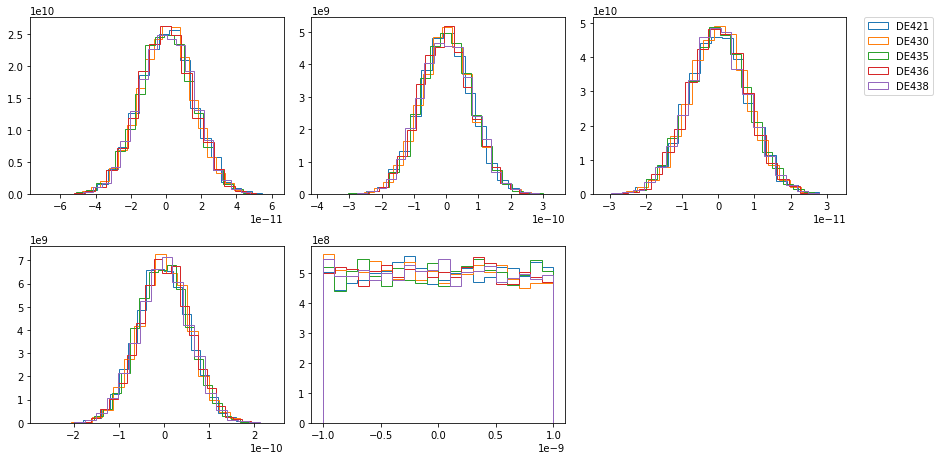

In [158]:
pp.figure(figsize=(12,6.5))

for i,var in enumerate(['M5', 'M6', 'M7', 'M8', 'r']):
    pp.subplot(2,3,i+1)
    
    for eph in ['DE421','DE430','DE435','DE436','DE438']:    
        pp.hist(dm_setIII[eph][:,i],
                histtype='step', density=True, bins=20, label=eph) # + ' 11yr')    
    if i == 2:
        pp.legend(bbox_to_anchor=(1.05, 1.03))
    
pp.tight_layout()

# pp.savefig('setIII-posteriors.pdf',bbox_inches='tight')

Parameter index.

In [159]:
parind = {'DMW': 0, 'DP': 1, 'DQ': 2, 'EDW': 3, 'DA': 4, 'DE': 5}
apcind = parind

Note that `setIIIpartials` has units of AU/radian; however Enterprise interprets the SVD basis as s/radian; thus the chain coefficients are too large by a factor of 500 s (AU/c).

In [160]:
AU = 149597870700

Posteriors for Jupiter set III parameters, shown against the DE434 uncertainty estimates

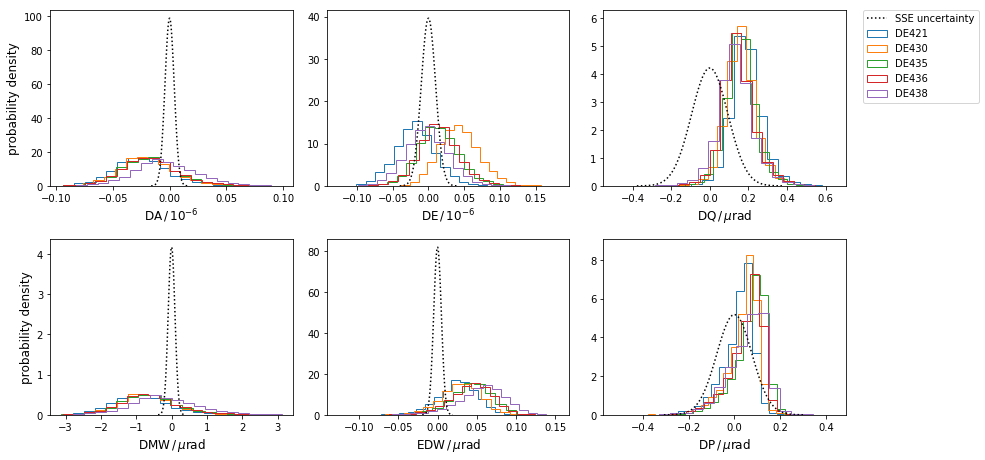

In [161]:
pp.figure(figsize=(12,6.5))

for i,var in enumerate(['DA', 'DE', 'DQ', 'DMW', 'EDW', 'DP']):
    pp.subplot(2,3,i+1)

    sigma = math.sqrt(np.diag(APCSCALE1 * APCOV1)[apcind[var]]) / 1e-6    
    x = np.linspace(-4*sigma,4*sigma,100)
    p = np.exp(-x**2/(2*sigma**2)) / math.sqrt(2*math.pi*sigma**2)
    ph = sigma * np.random.randn(10000)
    
    sigma2 = math.sqrt(np.diag(APCSCALE2 * APCOV2)[apcind[var]]) / 1e-6
    p2 = np.exp(-x**2/(2*sigma2**2)) / math.sqrt(2*math.pi*sigma2**2)
    ph2 = sigma2 * np.random.randn(10000)
    
    for eph in ['DE421','DE430','DE435','DE436','DE438']:    
        pp.hist(de_setIII[eph][:,parind[var]] / (1e-3*AU/csec) / 1e-6,
                histtype='step', density=True, bins=20, label=eph) # + ' 11yr')
        # pp.title(var + '/1e-6')
        # pp.yscale('log', nonposy='clip')
        if var in ['DA','DE']:
            pp.xlabel(f'$\mathrm{{{var}}} \,/\, 10^{{-6}}$', fontsize=12)
        else:
            pp.xlabel(f'$\mathrm{{{var}}} \,/\, \mu \mathrm{{rad}}$', fontsize=12)

    ax = pp.axis()
    
    pp.plot(x,p,'k:',label='SSE uncertainty')
    # pp.plot(x,p2,'k')
    
    pp.axis(ymax=1.05 * max(np.max(p),ax[3])) # 2.5*ax[3])

    # pp.hist(ph,histtype='step',density=True,bins=20,color='k',ls=':',label='JPL1')
    # pp.hist(ph2,histtype='step',density=True,bins=20,color='k',label='JPL1')
    
    if i in [0,3]:
        pp.ylabel('probability density', fontsize=12)
    
    if i == 2:
        pp.legend(bbox_to_anchor=(1.05, 1.03))
    
pp.tight_layout()

try:
    pp.gcf().align_ylabels()
except:
    pass
    
# pp.savefig('setIII-posteriors.pdf',bbox_inches='tight')

#### Orbit corrections

Make sure we use the actual BayesEphem partials (same ordering, etc.)

In [162]:
set3partials = np.load('../data/setIII_partials/jupiter-setIII-xyz.npy')

In [163]:
# matrix for set III orbit partials 
apvec = np.zeros_like(set3partials)

# matrix for sampled coefficients for BayesEphem'ed DE436, model-2A
cfs = np.zeros_like(de_setIII['DE436'])

# matrix for DE434 set III covariance matrix
apcov = np.zeros_like(APCOV1)

# fill them up!
for i,vi in enumerate(['DA', 'DE', 'DQ', 'DMW', 'EDW', 'DP']):
    apvec[i,:,:] = set3partials[parind[vi],:,:]
    cfs[:,i] = de_setIII['DE436'][:,parind[vi]]
    
    for j,vj in enumerate(['DA', 'DE', 'DQ', 'DMW', 'EDW', 'DP']):
        apcov[i,j] = APCSCALE1 * APCOV1[apcind[vi], apcind[vj]]
        
L = sla.cholesky(apcov)

Compute mean and standard deviation by averaging over chains and over random coefficients distributed with apcov (using the Cholesky multiplication method).

In [164]:
xs = 1e-3 * AU * np.einsum('li,ijk->ljk',cfs/(1e-3*AU/csec),apvec)
xm, xv = np.mean(xs,axis=0), np.sqrt(np.var(xs,axis=0))

ys = (1e-3 * AU * np.einsum('il,ijk->ljk',L.T @ np.random.randn(6,10000),apvec))
ym, yv = np.mean(ys,axis=0), np.sqrt(np.var(ys,axis=0))

...and plot!

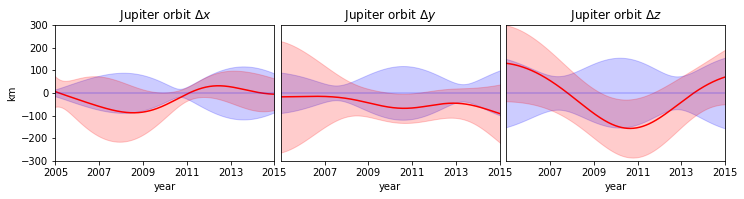

In [165]:
pp.figure(figsize=(12,2.5))

tyr = 1960 + (jdates - 2436934.5)/365.25

for i in range(3):
    pp.subplot(1,3,i+1)

    pp.fill_between(tyr, ym[:,i] - 2*yv[:,i], ym[:,i] + 2*yv[:,i], color='b', alpha=0.2)
    
    pp.fill_between(tyr, xm[:,i] - 2*xv[:,i], xm[:,i] + 2*xv[:,i], color='r', alpha=0.2)
    pp.plot(tyr, xm[:,i], 'r')
    
    pp.xlabel('year')
    if i == 0:
        pp.ylabel('km')
        pp.xticks([2005,2007,2009,2011,2013,2015])
    else:
        pp.yticks([])
        pp.xticks([2007,2009,2011,2013,2015])
        
    c = ['x','y','z'][i]
    pp.title(f"Jupiter orbit $\Delta {c}$")
    pp.axis(ymin=-300,ymax=300,xmin=2005,xmax=2015)
    
    pp.axhline(0,c='b',alpha=0.2)
    
pp.subplots_adjust(wspace=0.03)

# pp.savefig('orbit-corrections.pdf')

Similar plot, many realizations.

/Users/vallis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


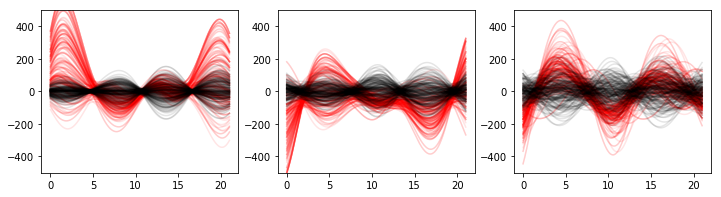

In [167]:
pp.figure(figsize=(12,3))
n = 200

for i in range(200):
    cf = cfs[random.randint(0,n),:] / (1e-3*AU/csec)
    
    x = (1e-3 * AU * np.einsum('i,ijk->jk',cf,apvec))

    for j in range(3):
        pp.subplot(1,3,j+1)
        pp.plot((jdates - jdates[0])/365.25, x[:,j], color='r', alpha=0.1)
        pp.axis(ymin=-500,ymax=500);
    
for i in range(200):
    # km
    x = (1e-3 * AU * np.einsum('i,ijk->jk',L.T @ np.random.randn(6),apvec))

    for j in range(3):
        pp.subplot(1,3,j+1)
        pp.plot((jdates - jdates[0])/365.25, x[:,j], color='k', alpha=0.1)
        # pp.axis(ymin=-50,ymax=50);

Now using the JPL DE438 uncertainty...

In [168]:
apcov = np.zeros_like(APCOV2)
apvec = np.zeros_like(set3partials)

cfs = np.zeros_like(de_setIII['DE436'])

for i,vi in enumerate(['DA', 'DE', 'DQ', 'DMW', 'EDW', 'DP']):
    apvec[i,:,:] = set3partials[parind[vi],:,:]
    cfs[:,i] = de_setIII['DE436'][:,parind[vi]]
    
    for j,vj in enumerate(['DA', 'DE', 'DQ', 'DMW', 'EDW', 'DP']):
        apcov[i,j] = APCSCALE2 * APCOV2[apcind[vi], apcind[vj]]
        
L = sla.cholesky(apcov)

It's a 10-km RMS.

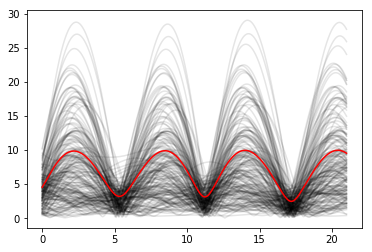

In [169]:
y = np.zeros((200,len(jdates)),'d')

for i in range(200):
    # km
    x = (1e-3 * AU * np.einsum('i,ijk->jk',L.T @ np.random.randn(6),apvec))

    y[i,:] = np.sqrt(x[:,0]**2 + x[:,1]**2 + x[:,2]**2)
    pp.plot((jdates - jdates[0])/365.25, y[i,:], color='k', alpha=0.1)
    
pp.plot((jdates - jdates[0])/365.25, np.sqrt(np.mean(y**2,axis=0)), color='r')

Compare RMS 3D errors for PTA posteriors and DE438 covariance.

Text(0,0.5,'km')

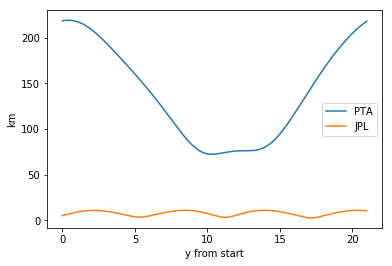

In [170]:
n = de_setIII['DE436'].shape[0]

md = np.zeros((200,2000,3),'d')
md1 = np.zeros((200,2000,3),'d')

for i in range(200):
    cf = cfs[random.randint(0,n),:] / (1e-3*AU/csec)
    md[i,:,:] = 1e-3 * AU * np.einsum('i,ijk->jk',cf,apvec)
    md1[i,:,:] = (1e-3 * AU * np.einsum('i,ijk->jk',L.T @ np.random.randn(6),apvec))
    
md = np.sqrt(np.sum(np.var(md, axis=0),axis=1))
md1 = np.sqrt(np.sum(np.var(md1, axis=0),axis=1))

pp.plot((jdates - jdates[0])/365.25, md, label='PTA')
pp.plot((jdates - jdates[0])/365.25, md1, label='JPL')

pp.legend()

pp.xlabel('y from start')
pp.ylabel('km')